In [56]:
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import plotly.graph_objects as go
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import colors as mcolors
from matplotlib.colors import ListedColormap
from scipy.stats import linregress
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.cluster import KMeans
from tabulate import tabulate
from collections import Counter
from sklearn.metrics import silhouette_samples

%matplotlib inline

In [2]:
# Initialize Plotly for use in the notebook
from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)

## Data Gathering

In [3]:
customer_demographics_df = pd.read_csv("./data/Customer_demographics_data.csv") #, encoding='latin1')
customer_demographics_df

ID  Gender Ever_Married  Age Graduated     Profession  \
0     3824657.0    Male           No   22        No     Healthcare   
1     3717191.0  Female          Yes   38       Yes       Engineer   
2     3581921.0  Female          Yes   67       Yes       Engineer   
3     3759999.0    Male          Yes   67       Yes         Lawyer   
4     3306626.0  Female          Yes   40       Yes  Entertainment   
...         ...     ...          ...  ...       ...            ...   
8063        NaN    Male           No   22        No            NaN   
8064        NaN    Male           No   35        No      Executive   
8065        NaN  Female           No   33       Yes     Healthcare   
8066        NaN  Female           No   27       Yes     Healthcare   
8067        NaN    Male          Yes   37       Yes      Executive   

      Work_Experience Spending_Score  Family_Size  Var_1  
0                 1.0            Low          4.0  Cat_4  
1                 NaN        Average          3.0  Cat_4  
2                 1.0            Low          1.0  Cat_6  
3                 0.0           High          2.0  Cat_6  
4                 NaN           High          6.0  Cat_6  
...               ...            ...          ...    ...  
8063              0.0            Low          7.0  Cat_1  
8064              3.0            Low          4.0  Cat_4  
8065              1.0            Low          1.0  Cat_6  
8066              1.0            Low          4.0  Cat_6  
8067              0.0        Average          3.0  Cat_4  

[8068 rows x 10 columns]

In [4]:
customer_demographics_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8068 entries, 0 to 8067
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ID               3333 non-null   float64
 1   Gender           8068 non-null   object 
 2   Ever_Married     7928 non-null   object 
 3   Age              8068 non-null   int64  
 4   Graduated        7990 non-null   object 
 5   Profession       7944 non-null   object 
 6   Work_Experience  7239 non-null   float64
 7   Spending_Score   8068 non-null   object 
 8   Family_Size      7733 non-null   float64
 9   Var_1            7992 non-null   object 
dtypes: float64(3), int64(1), object(6)
memory usage: 630.4+ KB


In [5]:
customer_demographics_df.isnull().sum()

ID                 4735
Gender                0
Ever_Married        140
Age                   0
Graduated            78
Profession          124
Work_Experience     829
Spending_Score        0
Family_Size         335
Var_1                76
dtype: int64

In [6]:
invoice_df = pd.read_csv(r'./data/Customer_invoice_data.csv', encoding='latin1')

In [7]:
invoice_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   ï»¿InvoiceNo  541909 non-null  object 
 1   StockCode     541909 non-null  object 
 2   Description   540455 non-null  object 
 3   Quantity      541909 non-null  int64  
 4   InvoiceDate   541909 non-null  object 
 5   UnitPrice     541909 non-null  float64
 6   CustomerID    406829 non-null  float64
 7   Country       541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [8]:
print(invoice_df.isnull().sum())

ï»¿InvoiceNo         0
StockCode            0
Description       1454
Quantity             0
InvoiceDate          0
UnitPrice            0
CustomerID      135080
Country              0
dtype: int64


In [9]:
# read in the data (downloaded from Kaggle)
cb_df = pd.read_csv("./data/Customer_behaviour_data.csv", delimiter=';')

# print the first 5 rows
cb_df.head()

account length  location code  user id credit card info save push status  \
0             128            415  3824657                    no         yes   
1             107            415  3717191                    no         yes   
2             137            415  3581921                    no          no   
3              84            408  3759999                   yes          no   
4              75            415  3306626                   yes          no   

   add to wishlist  desktop sessions  app sessions  desktop transactions  \
0               25               265            45                    17   
1               26               162            27                    17   
2                0               243            41                    10   
3                0               299            51                     5   
4                0               167            28                    13   

   total product detail views  session duration  promotion clicks  \
0                         110               197                87   
1                         123               196               103   
2                         114               121               110   
3                          71                62                88   
4                         113               148               122   

  avg order value  sale product views discount rate per visited products  \
0           244,7                  91                              11,01   
1           254,4                 103                              11,45   
2           162,6                 104                               7,32   
3           196,9                  89                               8,86   
4           186,9                 121                               8,41   

  product detail view per app session  app transactions  \
0                                  10                 3   
1                                13,7                 3   
2                                12,2                 5   
3                                 6,6                 7   
4                                10,1                 3   

  add to cart per session  customer service calls  churn  
0                     2,7                       1      0  
1                     3,7                       1      0  
2                    3,29                       0      0  
3                    1,78                       2      0  
4                    2,73                       3      0

In [10]:
cb_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 20 columns):
 #   Column                               Non-Null Count  Dtype 
---  ------                               --------------  ----- 
 0   account length                       3333 non-null   int64 
 1   location code                        3333 non-null   int64 
 2   user id                              3333 non-null   int64 
 3   credit card info save                3333 non-null   object
 4   push status                          3333 non-null   object
 5   add to wishlist                      3333 non-null   int64 
 6   desktop sessions                     3333 non-null   int64 
 7   app sessions                         3333 non-null   int64 
 8   desktop transactions                 3333 non-null   int64 
 9   total product detail views           3333 non-null   int64 
 10  session duration                     3333 non-null   int64 
 11  promotion clicks                     3333 n

In [11]:
print(cb_df.isnull().sum())

account length                         0
location code                          0
user id                                0
credit card info save                  0
push status                            0
add to wishlist                        0
desktop sessions                       0
app sessions                           0
desktop transactions                   0
total product detail views             0
session duration                       0
promotion clicks                       0
avg order value                        0
sale product views                     0
discount rate per visited products     0
product detail view per app session    0
app transactions                       0
add to cart per session                0
customer service calls                 0
churn                                  0
dtype: int64


## Data Cleaning

### Customer Demographics Data

#### Missing Value Treatmeant

In [15]:
customer_demographics_df.dropna(subset=["ID"], inplace=True)
customer_demographics_df["ID"]= customer_demographics_df["ID"].astype(int)

In [16]:
customer_demographics_df['Ever_Married'].unique()
customer_demographics_df['Ever_Married'].fillna("Not Available",inplace=True)
customer_demographics_df['Ever_Married'].unique()

array(['No', 'Yes', 'Not Available'], dtype=object)

In [17]:
customer_demographics_df['Graduated'].unique()
customer_demographics_df['Graduated'].fillna("Not Available",inplace=True)
customer_demographics_df['Graduated'].unique()

array(['No', 'Yes', 'Not Available'], dtype=object)

In [18]:
customer_demographics_df['Profession'].unique()
customer_demographics_df['Profession'].fillna("Not Available",inplace=True)
customer_demographics_df['Profession'].unique()

array(['Healthcare', 'Engineer', 'Lawyer', 'Entertainment', 'Artist',
       'Executive', 'Doctor', 'Homemaker', 'Marketing', 'Not Available'],
      dtype=object)

In [19]:
customer_demographics_df['Work_Experience'].unique()
customer_demographics_df['Work_Experience'].fillna(0,inplace=True)
customer_demographics_df['Work_Experience'] = customer_demographics_df['Work_Experience'].astype(int)
customer_demographics_df['Work_Experience'].unique()

array([ 1,  0,  4,  9, 12,  3, 13,  5,  8, 14,  7,  2,  6, 10, 11])

In [20]:
customer_demographics_df['Family_Size'].unique()
customer_demographics_df['Family_Size'].fillna(0,inplace=True)
customer_demographics_df['Family_Size'] = customer_demographics_df['Family_Size'].astype(int)
customer_demographics_df['Family_Size'].unique()

array([4, 3, 1, 2, 6, 0, 5, 8, 7, 9])

In [21]:
customer_demographics_df['Var_1'].unique()
customer_demographics_df['Var_1'].fillna("Not Available",inplace=True)
customer_demographics_df['Var_1'].unique()

array(['Cat_4', 'Cat_6', 'Cat_7', 'Cat_3', 'Cat_1', 'Cat_2',
       'Not Available', 'Cat_5'], dtype=object)

In [22]:
customer_demographics_df.isnull().sum()

ID                 0
Gender             0
Ever_Married       0
Age                0
Graduated          0
Profession         0
Work_Experience    0
Spending_Score     0
Family_Size        0
Var_1              0
dtype: int64

In [23]:
customer_demographics_df.describe()

ID          Age  Work_Experience  Family_Size
count  3.333000e+03  3333.000000      3333.000000  3333.000000
mean   3.746291e+06    43.238524         2.370237     2.727573
std    2.746626e+05    16.599778         3.344430     1.587072
min    3.271058e+06    18.000000         0.000000     0.000000
25%    3.508680e+06    30.000000         0.000000     2.000000
50%    3.748187e+06    40.000000         1.000000     2.000000
75%    3.985970e+06    53.000000         3.000000     4.000000
max    4.229964e+06    89.000000        14.000000     9.000000

In [24]:
customer_demographics_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3333 entries, 0 to 3332
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   ID               3333 non-null   int32 
 1   Gender           3333 non-null   object
 2   Ever_Married     3333 non-null   object
 3   Age              3333 non-null   int64 
 4   Graduated        3333 non-null   object
 5   Profession       3333 non-null   object
 6   Work_Experience  3333 non-null   int32 
 7   Spending_Score   3333 non-null   object
 8   Family_Size      3333 non-null   int32 
 9   Var_1            3333 non-null   object
dtypes: int32(3), int64(1), object(6)
memory usage: 247.4+ KB


In [25]:
customer_demographics_df['Spending_Score'].unique()

array(['Low', 'Average', 'High'], dtype=object)

#### Checking for Duplicates

In [26]:
customer_demographics_df

ID  Gender Ever_Married  Age Graduated     Profession  \
0     3824657    Male           No   22        No     Healthcare   
1     3717191  Female          Yes   38       Yes       Engineer   
2     3581921  Female          Yes   67       Yes       Engineer   
3     3759999    Male          Yes   67       Yes         Lawyer   
4     3306626  Female          Yes   40       Yes  Entertainment   
...       ...     ...          ...  ...       ...            ...   
3328  4144276    Male           No   18        No     Healthcare   
3329  3703271  Female           No   27        No       Engineer   
3330  3288230  Female          Yes   62       Yes         Artist   
3331  3646381    Male          Yes   68        No         Artist   
3332  4004344    Male          Yes   42       Yes  Entertainment   

      Work_Experience Spending_Score  Family_Size  Var_1  
0                   1            Low            4  Cat_4  
1                   0        Average            3  Cat_4  
2                   1            Low            1  Cat_6  
3                   0           High            2  Cat_6  
4                   0           High            6  Cat_6  
...               ...            ...          ...    ...  
3328                6            Low            7  Cat_6  
3329                0            Low            2  Cat_6  
3330                0        Average            3  Cat_6  
3331                0            Low            1  Cat_6  
3332                0        Average            2  Cat_4  

[3333 rows x 10 columns]

In [27]:
customer_demographics_df[customer_demographics_df.duplicated()]

Empty DataFrame
Columns: [ID, Gender, Ever_Married, Age, Graduated, Profession, Work_Experience, Spending_Score, Family_Size, Var_1]
Index: []

### Customer Invoice Data

#### Missing Value Treatment

In [28]:
invoice_df.columns = ['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country']

In [29]:
# dropping customerID rows with null values
invoice_df = invoice_df.dropna()

In [30]:
# checking for missing data
print(invoice_df.isnull().sum())

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64


#### Checking for Duplicates

In [31]:
duplicates = invoice_df[invoice_df.duplicated()]

# Display duplicate rows
print("Duplicate Rows:")
print(duplicates)

Duplicate Rows:
       InvoiceNo StockCode                        Description  Quantity  \
517       536409     21866        UNION JACK FLAG LUGGAGE TAG         1   
527       536409     22866      HAND WARMER SCOTTY DOG DESIGN         1   
537       536409     22900    SET 2 TEA TOWELS I LOVE LONDON          1   
539       536409     22111       SCOTTIE DOG HOT WATER BOTTLE         1   
555       536412     22327  ROUND SNACK BOXES SET OF 4 SKULLS         1   
...          ...       ...                                ...       ...   
541675    581538     22068        BLACK PIRATE TREASURE CHEST         1   
541689    581538     23318     BOX OF 6 MINI VINTAGE CRACKERS         1   
541692    581538     22992             REVOLVER WOODEN RULER          1   
541699    581538     22694                       WICKER STAR          1   
541701    581538     23343       JUMBO BAG VINTAGE CHRISTMAS          1   

             InvoiceDate  UnitPrice  CustomerID         Country  
517     12/01/201

In [33]:
# dropping the duplicated rows
invoice_df = invoice_df[~invoice_df.duplicated(keep=False)]

In [32]:
invoice_df.loc[:, 'CustomerID'] = pd.to_numeric(invoice_df.loc[:, 'CustomerID'], errors='coerce', downcast='integer')

In [34]:
#Treating Cancellation Transactions
# Filter out the rows with InvoiceNo starting with "C" and create a new column indicating the transaction status
invoice_df['Transaction_Status'] = np.where(invoice_df['InvoiceNo'].astype(str).str.startswith('C'), 'Cancelled', 'Completed')

# Analyze the characteristics of these rows (considering the new column)
cancelled_transactions = invoice_df[invoice_df['Transaction_Status'] == 'Cancelled']
cancelled_transactions.describe().drop('CustomerID', axis=1)

Quantity     UnitPrice
count   8844.000000   8844.000000
mean     -30.673677     18.945301
std     1174.024862    445.894331
min   -80995.000000      0.010000
25%       -6.000000      1.450000
50%       -2.000000      2.950000
75%       -1.000000      4.950000
max       -1.000000  38970.000000

In [36]:
# Finding the percentage of cancelled transactions
cancelled_percentage = (cancelled_transactions.shape[0] / invoice_df.shape[0]) * 100

# Printing the percentage of cancelled transactions
print(f"The percentage of cancelled transactions in the dataset is: {cancelled_percentage:.2f}%")

The percentage of cancelled transactions in the dataset is: 2.23%


In [37]:
# Finding the number of unique stock codes
unique_stock_codes = invoice_df['StockCode'].nunique()

# Printing the number of unique stock codes
print(f"The number of unique stock codes in the dataset is: {unique_stock_codes}")

The number of unique stock codes in the dataset is: 3684


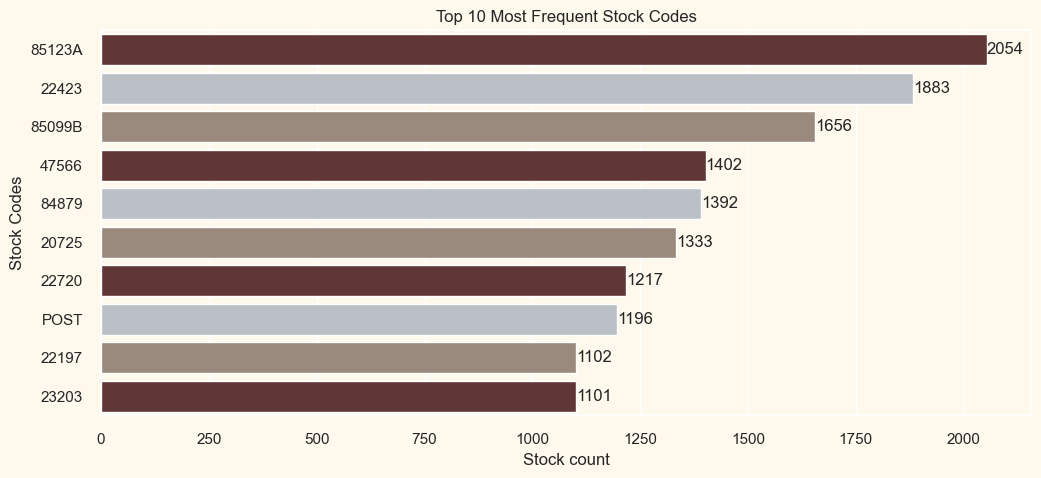

In [59]:
top_10_stock_codes = invoice_df['StockCode'].value_counts().head(10)
top_10_stock_codes = top_10_stock_codes.reset_index()
top_10_stock_codes.columns = ['StockCode', 'Percentage']

# Set the color palette
# colors = ["#682F2F","#B9C0C9", "#9F8A78","#F3AB60"]
# palette=["#682F2F","#B9C0C9", "#9F8A78","#F3AB60"]
# colors = ["#682F2F","#B9C0C9", "#9F8A78"]


sns.set(rc={"axes.facecolor":"#FFF9ED","figure.facecolor":"#FFF9ED"})
pallet = ["#682F2F", "#9E726F", "#D6B2B1", "#B9C0C9", "#9F8A78", "#F3AB60"]
cmap = mcolors.ListedColormap(["#682F2F", "#9E726F", "#D6B2B1", "#B9C0C9", "#9F8A78", "#F3AB60"])

# Plotting the top 10 most frequent stock codes using seaborn
plt.figure(figsize=(12, 5))
ax = sns.barplot(y='StockCode', x='Percentage', data=top_10_stock_codes, palette=["#682F2F","#B9C0C9", "#9F8A78"])

# Set the facecolor to light yellow
# ax.set_facecolor('#F3AB60')  # light yellow color code
# plt.gcf().set_facecolor('#F3AB60')  # set the background of the figure as well

# Adding the percentage frequency on the bars
for index, (code, value) in enumerate(zip(top_10_stock_codes['StockCode'], top_10_stock_codes['Percentage'])):
    plt.text(value, index, f'{value}', va='center')

plt.title('Top 10 Most Frequent Stock Codes')
plt.xlabel('Stock count')
plt.ylabel('Stock Codes')

# Invert y-axis to have the highest percentage at the top of the plot
# plt.gca().invert_yaxis()
# plt.show()
# Save the figure
plt.savefig('top_10_stock_codes.png', bbox_inches='tight')
# plt.savefig('top_10_stock_codes.png', bbox_inches='tight', facecolor='#F3AB60')
plt.show()

# Save the figure
# plt.savefig('top_10_stock_codes.png', bbox_inches='tight', facecolor='#FFFFE0')

In [62]:
temp = invoice_df[['CustomerID', 'InvoiceNo', 'Country']].groupby(['CustomerID', 'InvoiceNo', 'Country']).count()
temp = temp.reset_index(drop = False)
countries = temp['Country'].value_counts()
print('Number of countries in dataframe: {}'.format(len(countries)))

Number of countries in dataframe: 37


In [228]:
temp['Country'].unique()

array(['United Kingdom', 'EIRE', 'Germany', 'Poland', 'France',
       'Switzerland', 'Japan', 'Spain', 'Bahrain', 'Finland', 'Australia',
       'Portugal', 'Italy', 'Channel Islands', 'Denmark', 'Canada',
       'Belgium', 'USA', 'Malta', 'Greece', 'Cyprus', 'Norway', 'Austria',
       'Sweden', 'Singapore', 'Unspecified', 'Netherlands',
       'Saudi Arabia', 'Iceland', 'Brazil', 'Israel',
       'European Community', 'RSA', 'United Arab Emirates',
       'Czech Republic', 'Lebanon', 'Lithuania'], dtype=object)

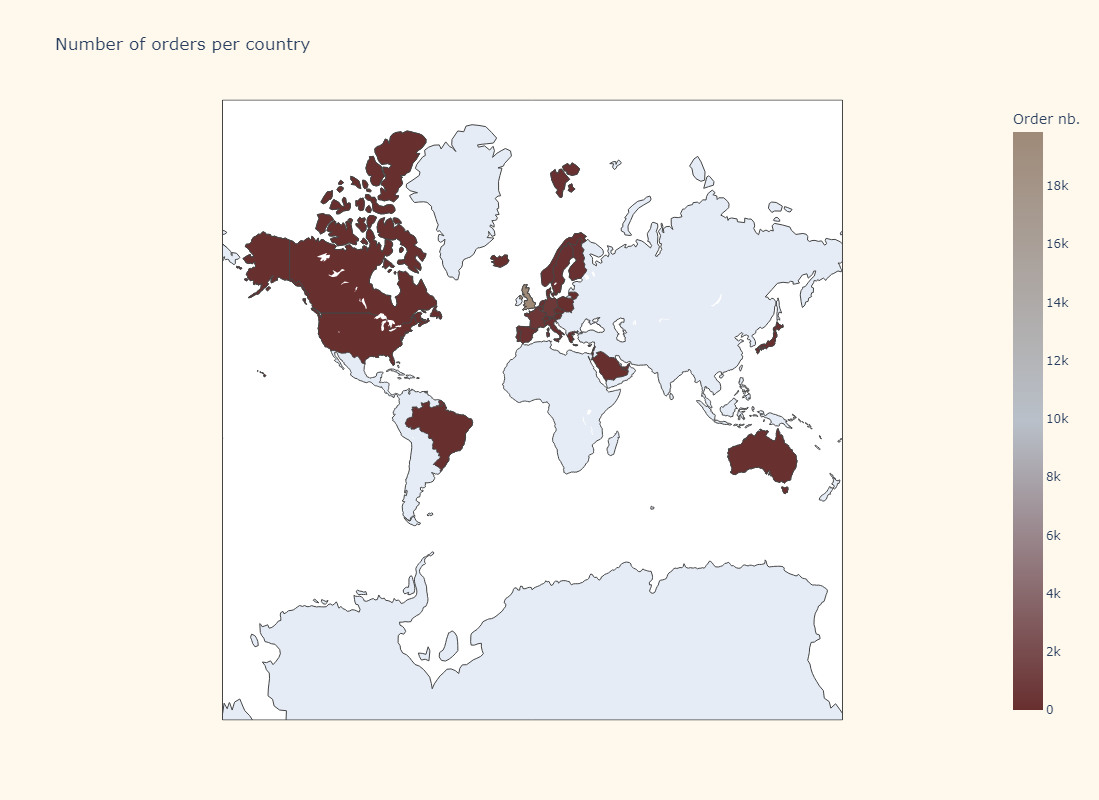

In [226]:
# import plotly.graph_objs as go
# from plotly.offline import iplot

# Assuming 'countries' is a pandas Series with country names as index
# and the number of orders as values. Replace 'countries' with your actual data.

data = dict(
    type='choropleth',
    locations=countries.index,  # Here 'countries' should be your pandas Series or DataFrame.
    locationmode='country names',
    z=countries,  # Here 'countries' should be your pandas Series or DataFrame.
    text=countries.index,
    colorbar={'title': 'Order nb.'},
    colorscale=[
        [0, '#682F2F'],
        [0.5, '#B9C0C9'],
        [1, '#9F8A78']
    ],
    reversescale=False
)

layout = dict(
    title='Number of orders per country',
    geo=dict(
        showframe=True,
        projection={'type': 'mercator'}
    ),
    height=800,  # Adjust the height if needed
    width=1200,  # Adjust the width if needed
    paper_bgcolor='#FFF9ED',
    plot_bgcolor='#FFF9ED'
)

choromap = go.Figure(data=[data], layout=layout)
iplot(choromap, validate=False)

In [71]:
df_cleaned = invoice_df.copy(deep = True)
df_cleaned['QuantityCanceled'] = 0

# entry_to_remove = [] ; doubtfull_entry = []

# for index, col in  invoice_df.iterrows():
#     if (col['Quantity'] > 0) or col['Description'] == 'Discount': continue        
#     df_test = invoice_df[(invoice_df['CustomerID'] == col['CustomerID']) &
#                          (invoice_df['StockCode']  == col['StockCode']) & 
#                          (invoice_df['InvoiceDate'] < col['InvoiceDate']) & 
#                          (invoice_df['Quantity']   > 0)].copy()
#     #_________________________________
#     # Cancelation WITHOUT counterpart
#     if (invoice_df.shape[0] == 0): 
#         doubtfull_entry.append(index)
#     #________________________________
#     # Cancelation WITH a counterpart
#     elif (invoice_df.shape[0] == 1): 
#         index_order = invoice_df.index[0]
#         df_cleaned.loc[index_order, 'QuantityCanceled'] = -col['Quantity']
#         entry_to_remove.append(index)        
#     #______________________________________________________________
#     # Various counterparts exist in orders: we delete the last one
#     elif (invoice_df.shape[0] > 1): 
#         invoice_df.sort_index(axis=0 ,ascending=False, inplace = True)        
#         for ind, val in invoice_df.iterrows():
#             if val['Quantity'] < -col['Quantity']: continue
#             df_cleaned.loc[ind, 'QuantityCanceled'] = -col['Quantity']
#             entry_to_remove.append(index) 
#             break  

In [77]:
df_cleaned['TotalPrice'] = df_cleaned['UnitPrice'] * (df_cleaned['Quantity'] - df_cleaned['QuantityCanceled'])
df_cleaned.sort_values('CustomerID')[:5]
df_cleaned = df_cleaned[df_cleaned['Transaction_Status'] != 'Cancelled']
df_cleaned['InvoiceDate'] = pd.to_datetime(df_cleaned['InvoiceDate'])

In [78]:
#___________________________________________
# somme des achats / utilisateur & commande
temp = df_cleaned.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['TotalPrice'].sum()
basket_price = temp.rename(columns = {'TotalPrice':'Basket Price'})
#_____________________
# date de la commande
df_cleaned['InvoiceDate_int'] = df_cleaned['InvoiceDate'].astype('int64')
temp = df_cleaned.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['InvoiceDate_int'].mean()
df_cleaned.drop('InvoiceDate_int', axis = 1, inplace = True)
basket_price.loc[:, 'InvoiceDate'] = pd.to_datetime(temp['InvoiceDate_int'])
#______________________________________
# selection des entrées significatives:
basket_price = basket_price[basket_price['Basket Price'] > 0]
basket_price.sort_values('CustomerID')[:6]

CustomerID InvoiceNo  Basket Price         InvoiceDate
0    3271058.0    562525        100.21 2011-08-05 13:35:00
1    3271058.0    580173         77.84 2011-12-02 11:43:00
26   3271319.0    551351       4390.56 2011-04-28 10:20:00
27   3271319.0    551747       2805.28 2011-05-04 11:00:00
28   3271319.0    555284       3056.72 2011-06-02 09:37:00
29   3271319.0    555285        362.70 2011-06-02 09:38:00

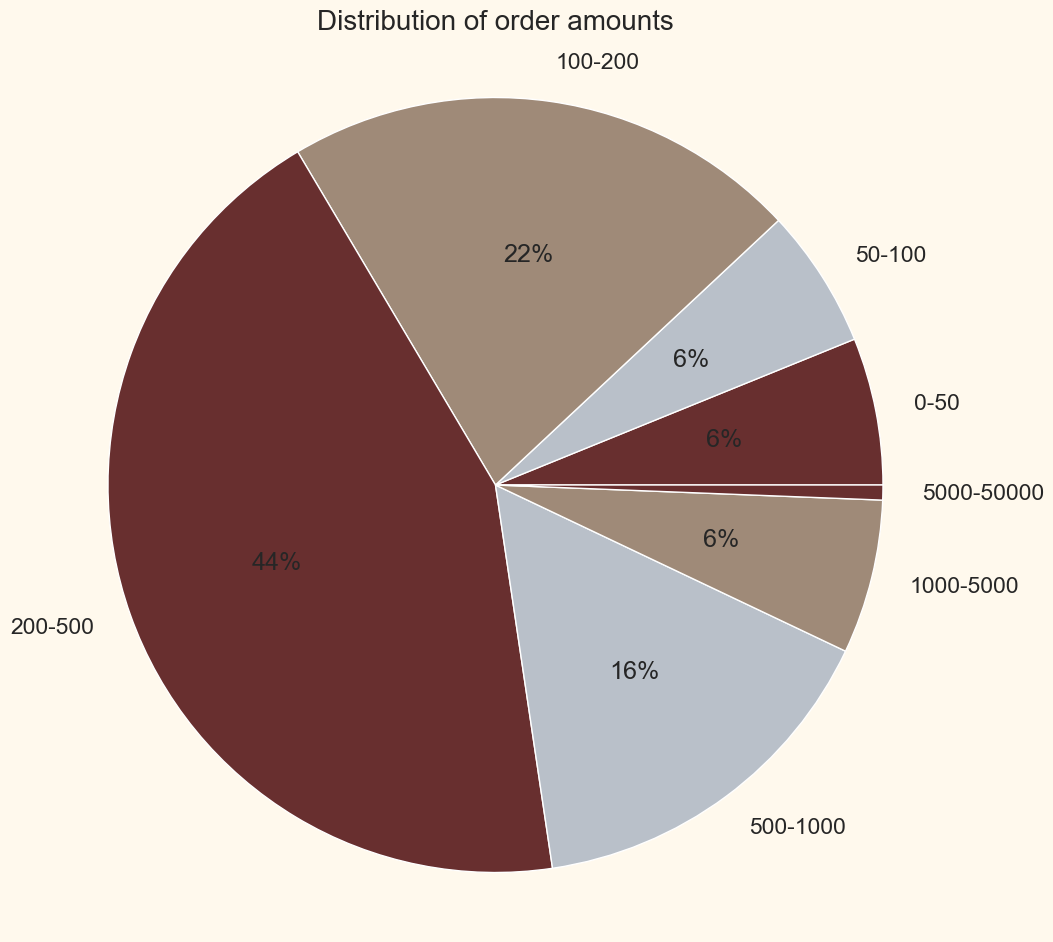

In [91]:
# import seaborn as sns
# import matplotlib.pyplot as plt


sns.set(rc={"axes.facecolor":"#FFF9ED","figure.facecolor":"#FFF9ED"})
pallet = ["#682F2F", "#9E726F", "#D6B2B1", "#B9C0C9", "#9F8A78", "#F3AB60"]
cmap = mcolors.ListedColormap(["#682F2F", "#9E726F", "#D6B2B1", "#B9C0C9", "#9F8A78", "#F3AB60"])

price_range = [0, 50, 100, 200, 500, 1000, 5000, 50000]
count_price = []
for i, price in enumerate(price_range):
    if i == 0: continue
    val = basket_price[(basket_price['Basket Price'] < price) &
                       (basket_price['Basket Price'] > price_range[i-1])]['Basket Price'].count()
    count_price.append(val)

labels = [ '{}-{}'.format(price_range[i-1], s) for i,s in enumerate(price_range) if i != 0]
sizes  = count_price
explode = [0.0 if sizes[i] < 100 else 0.0 for i in range(len(sizes))]

plt.figure(figsize=(11, 6))
sns.set(font_scale=1.5)
# sns.set_style("whitegrid")
# colors = sns.color_palette('pastel')[:len(sizes)]
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
        autopct=lambda x: '{:1.0f}%'.format(x) if x > 1 else '',
        shadow=False, startangle=0)
# plt.pie(sizes, explode=explode, colors=colors,
#         autopct=lambda x: '{:1.0f}%'.format(x) if x > 1 else '',
#         shadow=False, startangle=0)
plt.title("Distribution of order amounts", fontsize=20)
plt.subplots_adjust(top=1.6)
plt.axis('equal')

plt.savefig('Distribution_of_order_amounts.png', bbox_inches='tight')
plt.show()


#### It can be seen that the vast majority of orders concern relatively large purchases given that  ∼65% of purchases give prizes in excess of £ 200.

In [93]:
# basket_price
temp = invoice_df[['CustomerID', 'InvoiceNo', 'Country']].groupby(['CustomerID', 'InvoiceNo', 'Country']).count()
temp = temp.reset_index(drop = False)

In [94]:
temp2 = pd.merge(basket_price, temp, left_on=['CustomerID', 'InvoiceNo'], right_on=['CustomerID', 'InvoiceNo'], how='inner')

In [97]:
temp3 = temp2[['Country','Basket Price']].groupby(['Country'])['Basket Price'].sum()

In [ ]:
temp3

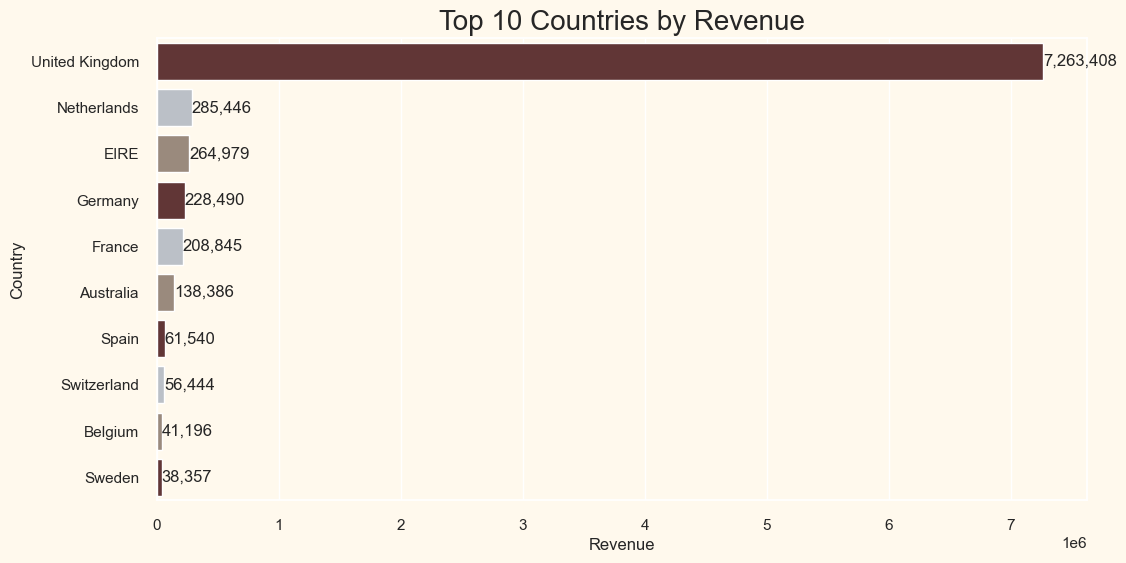

In [104]:
# temp3

top_countries = temp3.sort_values(ascending=False).head(10)

# Plotting
sns.set(rc={"axes.facecolor":"#FFF9ED","figure.facecolor":"#FFF9ED"})
pallet = ["#682F2F", "#9E726F", "#D6B2B1", "#B9C0C9", "#9F8A78", "#F3AB60"]
cmap = mcolors.ListedColormap(["#682F2F", "#9E726F", "#D6B2B1", "#B9C0C9", "#9F8A78", "#F3AB60"])

plt.figure(figsize=(12, 6))
sns.barplot(x=top_countries.values, y=top_countries.index, palette=["#682F2F","#B9C0C9", "#9F8A78"])

# Adding the percentage frequency on the bars
for index, value in enumerate(top_countries.values):
    plt.text(value, index, f'{value:,.0f}', va='center')
    
plt.xlabel('Revenue')
plt.ylabel('Country')
plt.title('Top 10 Countries by Revenue', fontsize=20)
plt.savefig('top_10_countries_generating_revenue.png', bbox_inches='tight')
# plt.savefig('top_10_stock_codes.png', bbox_inches='tight', facecolor='#F3AB60')
plt.show()

plt.show()


In [ ]:
#revenue and quantity together one plot
#Different countries where our data is present

#### Inferences on Stock Codes:
#### Product Variety: The dataset contains 3684 unique stock codes, indicating a substantial variety of products available in the online retail store. This diversity can potentially lead to the identification of distinct customer clusters, with preferences for different types of products.

#### Popular Items: A closer look at the top 10 most frequent stock codes can offer insights into the popular products or categories that are frequently purchased by customers.

#### Stock Code Anomalies: We observe that while most stock codes are composed of 5 or 6 characters, there are some anomalies like the code 'POST'. These anomalies might represent services or non-product transactions (perhaps postage fees) rather than actual products. To maintain the focus of the project, which is clustering based on product purchases and creating a recommendation system, these anomalies should be further investigated and possibly treated appropriately to ensure data integrity.

In [105]:
invoice_df
# Finding the number of numeric characters in each unique stock code
unique_stock_codes = invoice_df['StockCode'].unique()
numeric_char_counts_in_unique_codes = pd.Series(unique_stock_codes).apply(lambda x: sum(c.isdigit() for c in str(x))).value_counts()

# Printing the value counts for unique stock codes
print("Value counts of numeric character frequencies in unique stock codes:")
print("-"*70)
print(numeric_char_counts_in_unique_codes)

Value counts of numeric character frequencies in unique stock codes:
----------------------------------------------------------------------
5    3676
0       7
1       1
Name: count, dtype: int64


#### Inference:
#### The output indicates the following:

#### A majority of the unique stock codes (3676 out of 3684) contain exactly 5 numeric characters, which seems to be the standard format for representing product codes in this dataset.

#### There are a few anomalies: 7 stock codes contain no numeric characters and 1 stock code contains only 1 numeric character. These are clearly deviating from the standard format and need further investigation to understand their nature and whether they represent valid product transactions.

#### Now, let's identify the stock codes that contain 0 or 1 numeric characters to further understand these anomalies:

In [106]:
# Finding and printing the stock codes with 0 and 1 numeric characters
anomalous_stock_codes = [code for code in unique_stock_codes if sum(c.isdigit() for c in str(code)) in (0, 1)]

# Printing each stock code on a new line
print("Anomalous stock codes:")
print("-"*22)
for code in anomalous_stock_codes:
    print(code)

Anomalous stock codes:
----------------------
POST
M
BANK CHARGES
CRUK
DOT
C2
D
PADS


In [108]:
# Let's calculate the percentage of records with these anomalous stock codes:
# Calculating the percentage of records with these stock codes
percentage_anomalous = (invoice_df['StockCode'].isin(anomalous_stock_codes).sum() / len(invoice_df)) * 100

# Printing the percentage
print(f"The percentage of records with anomalous stock codes in the dataset is: {percentage_anomalous:.2f}%")

The percentage of records with anomalous stock codes in the dataset is: 0.48%


#### Inference:
#### Based on the analysis, we find that a very small proportion of the records, 0.48%, have anomalous stock codes, which deviate from the typical format observed in the majority of the data. Also, these anomalous codes are just a fraction among all unique stock codes (only 8 out of 3684).

#### These codes seem to represent non-product transactions like "BANK CHARGES", "POST" (possibly postage fees), etc. Since they do not represent actual products and are a very small proportion of the dataset, including them in the analysis might introduce noise and distort the clustering and recommendation system.

#### Strategy:
#### Given the context of the project, where the aim is to cluster customers based on their product purchasing behaviors and develop a product recommendation system, it would be prudent to exclude these records with anomalous stock codes from the dataset. This way, the focus remains strictly on genuine product transactions, which would lead to a more accurate and meaningful analysis.

In [109]:
# Removing rows with anomalous stock codes from the dataset
invoice_df = invoice_df[~invoice_df['StockCode'].isin(anomalous_stock_codes)]

In [110]:
# Getting the number of rows in the dataframe
invoice_df.shape[0]

394853

#### Cleaning Description Column : First, I will calculate the occurrence count of each unique description in the dataset. Then, I will plot the top 30 descriptions. This visualization will give a clear view of the highest occurring descriptions in the dataset:

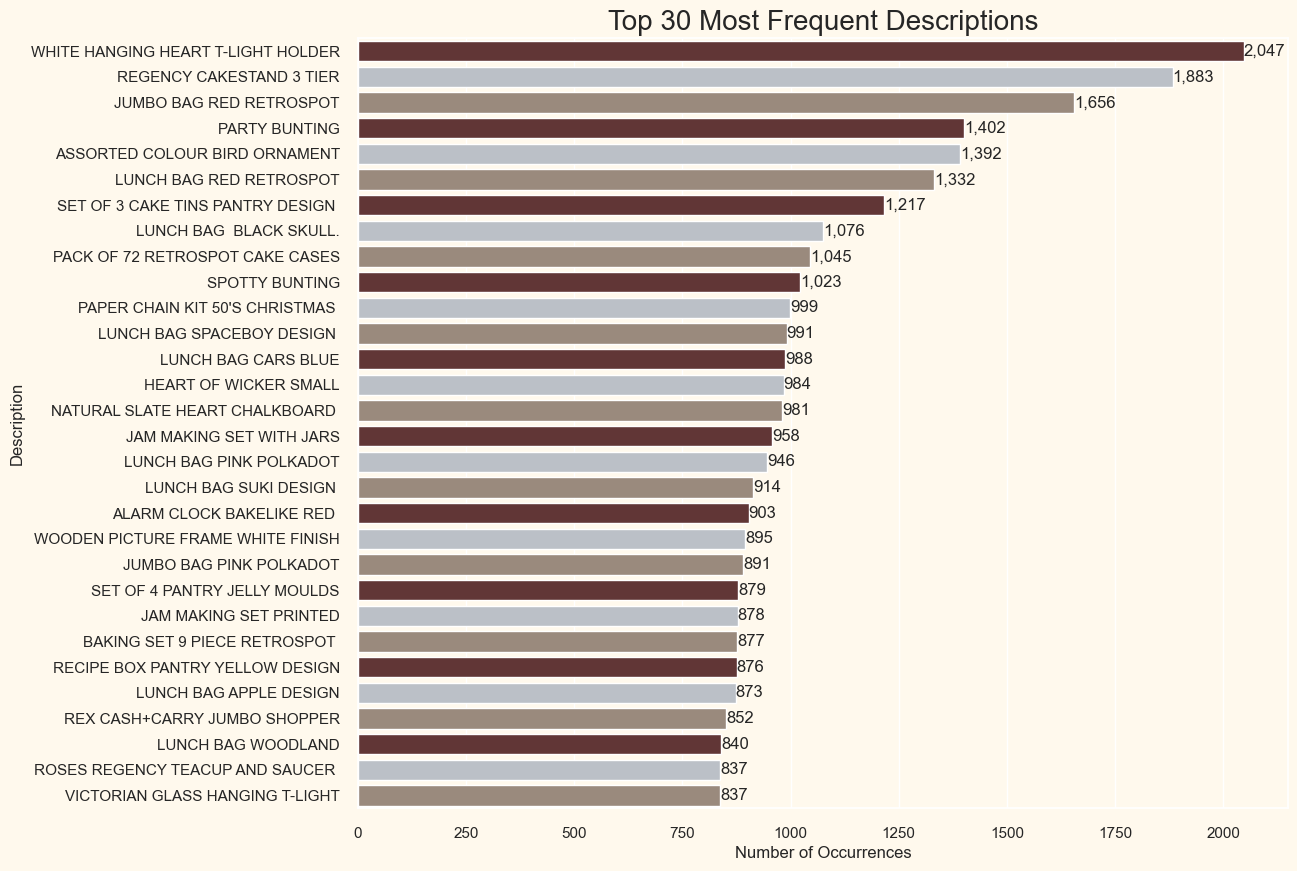

In [112]:
# Calculate the occurrence of each unique description and sort them
description_counts = invoice_df['Description'].value_counts()[:30]

# Plotting
sns.set(rc={"axes.facecolor":"#FFF9ED","figure.facecolor":"#FFF9ED"})
pallet = ["#682F2F", "#9E726F", "#D6B2B1", "#B9C0C9", "#9F8A78", "#F3AB60"]
cmap = mcolors.ListedColormap(["#682F2F", "#9E726F", "#D6B2B1", "#B9C0C9", "#9F8A78", "#F3AB60"])

plt.figure(figsize=(12, 10))
sns.barplot(x=description_counts.values, y=description_counts.index, palette=["#682F2F","#B9C0C9", "#9F8A78"])

# Adding the percentage frequency on the bars
for index, value in enumerate(description_counts.values):
    plt.text(value, index, f'{value:,.0f}', va='center')
    
plt.xlabel('Number of Occurrences')
plt.ylabel('Description')
plt.title('Top 30 Most Frequent Descriptions', fontsize=20)
# plt.title('Top 10 Countries by Revenue', fontsize=20)
plt.savefig('Top 30 Most Frequent Descriptions.png', bbox_inches='tight')
# plt.savefig('top_10_stock_codes.png', bbox_inches='tight', facecolor='#F3AB60')
plt.show()

plt.show()

#### Inferences on Descriptions:
#### The most frequent descriptions are generally household items, particularly those associated with kitchenware, lunch bags, and decorative items.

#### Interestingly, all the descriptions are in uppercase, which might be a standardized format for entering product descriptions in the database. However, considering the inconsistencies and anomalies encountered in the dataset so far, it would be prudent to check if there are descriptions entered in lowercase or a mix of case styles.

In [114]:
# Find unique descriptions containing lowercase characters
lowercase_descriptions = invoice_df['Description'].unique()
lowercase_descriptions = [desc for desc in lowercase_descriptions if any(char.islower() for char in desc)]

# Print the unique descriptions containing lowercase characters
print("The unique descriptions containing lowercase characters are:")
print("-"*60)
for desc in lowercase_descriptions:
    print(desc)

The unique descriptions containing lowercase characters are:
------------------------------------------------------------
BAG 500g SWIRLY MARBLES
BAG 250g SWIRLY MARBLES
BAG 125g SWIRLY MARBLES
FRENCH BLUE METAL DOOR SIGN No
POLYESTER FILLER PAD 40x40cm
Next Day Carriage
POLYESTER FILLER PAD 45x30cm
POLYESTER FILLER PAD 45x45cm
3 TRADITIONAl BISCUIT CUTTERS  SET
POLYESTER FILLER PAD 30CMx30CM
THE KING GIFT BAG 25x24x12cm
High Resolution Image
FOLK ART GREETING CARD,pack/12
NUMBER TILE VINTAGE FONT No 
POLYESTER FILLER PAD 65CMx65CM
NUMBER TILE COTTAGE GARDEN No
ESSENTIAL BALM 3.5g TIN IN ENVELOPE
FLOWERS HANDBAG blue and orange
POLYESTER FILLER PAD 60x40cm


#### Inference:
#### Upon reviewing the descriptions that contain lowercase characters, it is evident that some entries are not product descriptions, such as "Next Day Carriage" and "High Resolution Image". These entries seem to be unrelated to the actual products and might represent other types of information or service details.

#### Strategy:
#### Step 1: Remove the rows where the descriptions contain service-related information like "Next Day Carriage" and "High Resolution Image", as these do not represent actual products and would not contribute to the clustering and recommendation system we aim to build.

#### Step 2: For the remaining descriptions with mixed case, standardize the text to uppercase to maintain uniformity across the dataset. This will also assist in reducing the chances of having duplicate entries with different case styles.

#### By implementing the above strategy, we can enhance the quality of our dataset, making it more suitable for the analysis and modeling phases of our project.

In [115]:
service_related_descriptions = ["Next Day Carriage", "High Resolution Image"]

# Calculate the percentage of records with service-related descriptions
service_related_percentage = invoice_df[invoice_df['Description'].isin(service_related_descriptions)].shape[0] / invoice_df.shape[0] * 100

# Print the percentage of records with service-related descriptions
print(f"The percentage of records with service-related descriptions in the dataset is: {service_related_percentage:.2f}%")

# Remove rows with service-related information in the description
invoice_df = invoice_df[~invoice_df['Description'].isin(service_related_descriptions)]

# Standardize the text to uppercase to maintain uniformity across the dataset
invoice_df['Description'] = invoice_df['Description'].str.upper()

The percentage of records with service-related descriptions in the dataset is: 0.02%


In [117]:
# Getting the number of rows in the dataframe
invoice_df.shape[0]

394770

#### Treating Zero Unit Prices: In this step, first I am going to take a look at the statistical description of the UnitPrice column:

In [118]:
invoice_df['UnitPrice'].describe()

count    394770.000000
mean          2.911035
std           4.468562
min           0.000000
25%           1.250000
50%           1.950000
75%           3.750000
max         649.500000
Name: UnitPrice, dtype: float64

#### Inference:
#### The minimum unit price value is zero. This suggests that there are some transactions where the unit price is zero, potentially indicating a free item or a data entry error. To understand their nature, it is essential to investigate these zero unit price transactions further. A detailed analysis of the product descriptions associated with zero unit prices will be conducted to determine if they adhere to a specific pattern:

In [119]:
invoice_df[invoice_df['UnitPrice']==0].describe()[['Quantity']]

Quantity
count     33.000000
mean     420.515152
std     2176.713608
min        1.000000
25%        2.000000
50%       11.000000
75%       36.000000
max    12540.000000

#### Inferences on UnitPrice: 
#### The transactions with a unit price of zero are relatively few in number (33 transactions).

#### These transactions have a large variability in the quantity of items involved, ranging from 1 to 12540, with a substantial standard deviation.

#### Including these transactions in the clustering analysis might introduce noise and could potentially distort the customer behavior patterns identified by the clustering algorithm.

##### Strategy: Given the small number of these transactions and their potential to introduce noise in the data analysis, the strategy should be to remove these transactions from the dataset. This would help in maintaining a cleaner and more consistent dataset, which is essential for building an accurate and reliable clustering model and recommendation system.

In [120]:
invoice_df = invoice_df[invoice_df['UnitPrice'] > 0]

#### Outlier Treatment: In K-means clustering, the algorithm is sensitive to both the scale of data and the presence of outliers, as they can significantly influence the position of centroids, potentially leading to incorrect cluster assignments. However, considering the context of this project where the final goal is to understand customer behavior and preferences through K-means clustering, it would be more prudent to address the issue of outliers after the feature engineering phase where we create a customer-centric dataset. At this stage, the data is transactional, and removing outliers might eliminate valuable information that could play a crucial role in segmenting customers later on. Therefore, we will postpone the outlier treatment and proceed to the next stage for now.

In [121]:
invoice_df.reset_index(drop=True, inplace=True)

In [122]:
invoice_df.shape[0]

394737

#### Feature Engineering: In order to create a comprehensive customer-centric dataset for clustering and recommendation, the following features can be engineered from the available data:

#### RFM Features :
#### RFM is a method used for analyzing customer value and segmenting the customer base. It is an acronym that stands for:
#### 
Recency (R): This metric indicates how recently a customer has made a purchase. A lower recency value means the customer has purchased more recently, indicating higher engagement with the bran
d.#### 

Frequency (F): This metric signifies how often a customer makes a purchase within a certain period. A higher frequency value indicates a customer who interacts with the business more often, suggesting higher loyalty or satisfactio#### n.

Monetary (M): This metric represents the total amount of money a customer has spent over a certain period. Customers who have a higher monetary value have contributed more to the business, indicating their potential high lifetime va#### lue.

Together, these metrics help in understanding a customer's buying behavior and preferences, which is pivotal in personalizing marketing strategies and creating a recommendation system.

####  Recency (R) : In this step, we focus on understanding how recently a customer has made a purchase. This is a crucial aspect of customer segmentation as it helps in identifying the engagement level of customers. Here, I am going to define the following feature:

#### Days Since Last Purchase: This feature represents the number of days that have passed since the customer's last purchase. A lower value indicates that the customer has purchased recently, implying a higher engagement level with the business, whereas a higher value may indicate a lapse or decreased engagement. By understanding the recency of purchases, businesses can tailor their marketing strategies to re-engage customers who have not made purchases in a while, potentially increasing customer retention and fostering loyalty.

In [123]:
# Convert InvoiceDate to datetime type
invoice_df['InvoiceDate'] = pd.to_datetime(invoice_df['InvoiceDate'])

# Convert InvoiceDate to datetime and extract only the date
invoice_df['InvoiceDay'] = invoice_df['InvoiceDate'].dt.date

# Find the most recent purchase date for each customer
customer_data = invoice_df.groupby('CustomerID')['InvoiceDay'].max().reset_index()

# Find the most recent date in the entire dataset
most_recent_date = invoice_df['InvoiceDay'].max()

# Convert InvoiceDay to datetime type before subtraction
customer_data['InvoiceDay'] = pd.to_datetime(customer_data['InvoiceDay'])
most_recent_date = pd.to_datetime(most_recent_date)

# Calculate the number of days since the last purchase for each customer
customer_data['Days_Since_Last_Purchase'] = (most_recent_date - customer_data['InvoiceDay']).dt.days

# Remove the InvoiceDay column
customer_data.drop(columns=['InvoiceDay'], inplace=True)

In [124]:
customer_data.head()

CustomerID  Days_Since_Last_Purchase
0   3271058.0                         7
1   3271319.0                         3
2   3273053.0                        19
3   3273587.0                         1
4   3273850.0                         2

#### Frequency (F) In this step, I am going to create two features that quantify the frequency of a customer's engagement with the retailer:
#### 
Total Transactions: This feature represents the total number of transactions made by a customer. It helps in understanding the engagement level of a customer with the retailer.#### 

Total Products Purchased: This feature indicates the total number of products (sum of quantities) purchased by a customer across all transactions. It gives an insight into the customer's buying behavior in terms of the volume of products purchase#### d.

These features will be crucial in segmenting customers based on their buying frequency, which is a key aspect in determining customer segments for targeted marketing and personalized recommendations.

In [126]:
# Calculate the total number of transactions made by each customer
total_transactions = invoice_df.groupby('CustomerID')['InvoiceNo'].nunique().reset_index()
total_transactions.rename(columns={'InvoiceNo': 'Total_Transactions'}, inplace=True)

# Calculate the total number of products purchased by each customer
total_products_purchased = invoice_df.groupby('CustomerID')['Quantity'].sum().reset_index()
total_products_purchased.rename(columns={'Quantity': 'Total_Products_Purchased'}, inplace=True)

# Merge the new features into the customer_data dataframe
customer_data = pd.merge(customer_data, total_transactions, on='CustomerID')
customer_data = pd.merge(customer_data, total_products_purchased, on='CustomerID')

# Display the first few rows of the customer_data dataframe
customer_data.head()

CustomerID  Days_Since_Last_Purchase  Total_Transactions  \
0   3271058.0                         7                   3   
1   3271319.0                         3                  46   
2   3273053.0                        19                   6   
3   3273587.0                         1                  35   
4   3273850.0                         2                  16   

   Total_Products_Purchased  
0                        98  
1                     58286  
2                      2147  
3                     12072  
4                      1627

#### Monetary (M) : In this step, I am going to create two features that represent the monetary aspect of customer's transactions:

#### Total Spend: This feature represents the total amount of money spent by each customer. It is calculated as the sum of the product of UnitPrice and Quantity for all transactions made by a customer. This feature is crucial as it helps in identifying the total revenue generated by each customer, which is a direct indicator of a customer's value to the business.

#### Average Transaction Value: This feature is calculated as the Total Spend divided by the Total Transactions for each customer. It indicates the average value of a transaction carried out by a customer. This metric is useful in understanding the spending behavior of customers per transaction, which can assist in tailoring marketing strategies and offers to different customer segments based on their average spending patterns.

In [127]:
# Calculate the total spend by each customer
invoice_df['Total_Spend'] = invoice_df['UnitPrice'] * invoice_df['Quantity']
total_spend = invoice_df.groupby('CustomerID')['Total_Spend'].sum().reset_index()

# Calculate the average transaction value for each customer
average_transaction_value = total_spend.merge(total_transactions, on='CustomerID')
average_transaction_value['Average_Transaction_Value'] = average_transaction_value['Total_Spend'] / average_transaction_value['Total_Transactions']

# Merge the new features into the customer_data dataframe
customer_data = pd.merge(customer_data, total_spend, on='CustomerID')
customer_data = pd.merge(customer_data, average_transaction_value[['CustomerID', 'Average_Transaction_Value']], on='CustomerID')

# Display the first few rows of the customer_data dataframe
customer_data.head()

CustomerID  Days_Since_Last_Purchase  Total_Transactions  \
0   3271058.0                         7                   3   
1   3271319.0                         3                  46   
2   3273053.0                        19                   6   
3   3273587.0                         1                  35   
4   3273850.0                         2                  16   

   Total_Products_Purchased  Total_Spend  Average_Transaction_Value  
0                        98       176.60                  58.866667  
1                     58286     51389.49                1117.162826  
2                      2147      4386.06                 731.010000  
3                     12072     19145.20                 547.005714  
4                      1627      2412.04                 150.752500

#### Product Diversity: In this step, we are going to understand the diversity in the product purchase behavior of customers. Understanding product diversity can help in crafting personalized marketing strategies and product recommendations. Here, I am going to define the following feature:

#### Unique Products Purchased: This feature represents the number of distinct products bought by a customer. A higher value indicates that the customer has a diverse taste or preference, buying a wide range of products, while a lower value might indicate a focused or specific preference. Understanding the diversity in product purchases can help in segmenting customers based on their buying diversity, which can be a critical input in personalizing product recommendations.

In [128]:
# Calculate the number of unique products purchased by each customer
unique_products_purchased = invoice_df.groupby('CustomerID')['StockCode'].nunique().reset_index()
unique_products_purchased.rename(columns={'StockCode': 'Unique_Products_Purchased'}, inplace=True)

# Merge the new feature into the customer_data dataframe
customer_data = pd.merge(customer_data, unique_products_purchased, on='CustomerID')

# Display the first few rows of the customer_data dataframe
customer_data.head()

CustomerID  Days_Since_Last_Purchase  Total_Transactions  \
0   3271058.0                         7                   3   
1   3271319.0                         3                  46   
2   3273053.0                        19                   6   
3   3273587.0                         1                  35   
4   3273850.0                         2                  16   

   Total_Products_Purchased  Total_Spend  Average_Transaction_Value  \
0                        98       176.60                  58.866667   
1                     58286     51389.49                1117.162826   
2                      2147      4386.06                 731.010000   
3                     12072     19145.20                 547.005714   
4                      1627      2412.04                 150.752500   

   Unique_Products_Purchased  
0                         12  
1                        910  
2                        155  
3                        462  
4                        240

#### Behavioral Features: In this step, we aim to understand and capture the shopping patterns and behaviors of customers. These features will give us insights into the customers' preferences regarding when they like to shop, which can be crucial information for personalizing their shopping experience. Here are the features I am planning to introduce:
#### 
Average Days Between Purchases: This feature represents the average number of days a customer waits before making another purchase. Understanding this can help in predicting when the customer is likely to make their next purchase, which can be a crucial metric for targeted marketing and personalized promotions.#### 

Favorite Shopping Day: This denotes the day of the week when the customer shops the most. This information can help in identifying the preferred shopping days of different customer segments, which can be used to optimize marketing strategies and promotions for different days of the wee#### k.

Favorite Shopping Hour: This refers to the hour of the day when the customer shops the most. Identifying the favorite shopping hour can aid in optimizing the timing of marketing campaigns and promotions to align with the times when different customer segments are most act#### ive.

By including these behavioral features in our dataset, we can create a more rounded view of our customers, which will potentially enhance the effectiveness of the clustering algorithm, leading to more meaningful customer segments.

In [129]:
# Extract day of week and hour from InvoiceDate
invoice_df['Day_Of_Week'] = invoice_df['InvoiceDate'].dt.dayofweek
invoice_df['Hour'] = invoice_df['InvoiceDate'].dt.hour

# Calculate the average number of days between consecutive purchases
days_between_purchases = invoice_df.groupby('CustomerID')['InvoiceDay'].apply(lambda x: (x.diff().dropna()).apply(lambda y: y.days))
average_days_between_purchases = days_between_purchases.groupby('CustomerID').mean().reset_index()
average_days_between_purchases.rename(columns={'InvoiceDay': 'Average_Days_Between_Purchases'}, inplace=True)

# Find the favorite shopping day of the week
favorite_shopping_day = invoice_df.groupby(['CustomerID', 'Day_Of_Week']).size().reset_index(name='Count')
favorite_shopping_day = favorite_shopping_day.loc[favorite_shopping_day.groupby('CustomerID')['Count'].idxmax()][['CustomerID', 'Day_Of_Week']]

# Find the favorite shopping hour of the day
favorite_shopping_hour = invoice_df.groupby(['CustomerID', 'Hour']).size().reset_index(name='Count')
favorite_shopping_hour = favorite_shopping_hour.loc[favorite_shopping_hour.groupby('CustomerID')['Count'].idxmax()][['CustomerID', 'Hour']]

# Merge the new features into the customer_data dataframe
customer_data = pd.merge(customer_data, average_days_between_purchases, on='CustomerID')
customer_data = pd.merge(customer_data, favorite_shopping_day, on='CustomerID')
customer_data = pd.merge(customer_data, favorite_shopping_hour, on='CustomerID')

# Display the first few rows of the customer_data dataframe
customer_data.head()

CustomerID  Days_Since_Last_Purchase  Total_Transactions  \
0   3271058.0                         7                   3   
1   3271319.0                         3                  46   
2   3273053.0                        19                   6   
3   3273587.0                         1                  35   
4   3273850.0                         2                  16   

   Total_Products_Purchased  Total_Spend  Average_Transaction_Value  \
0                        98       176.60                  58.866667   
1                     58286     51389.49                1117.162826   
2                      2147      4386.06                 731.010000   
3                     12072     19145.20                 547.005714   
4                      1627      2412.04                 150.752500   

   Unique_Products_Purchased  Average_Days_Between_Purchases  Day_Of_Week  \
0                         12                       -9.916667            4   
1                        910                       -0.213517            3   
2                        155                       -2.073620            4   
3                        462                       -0.418118            0   
4                        240                       -1.217391            2   

   Hour  
0    13  
1    12  
2    10  
3    12  
4    11

#### Geographic Features: In this step, we will introduce a geographic feature that reflects the geographical location of customers. Understanding the geographic distribution of customers is pivotal for several reasons:
#### 
Country: This feature identifies the country where each customer is located. Including the country data can help us understand region-specific buying patterns and preferences. Different regions might have varying preferences and purchasing behaviors which can be critical in personalizing marketing strategies and inventory planning. Furthermore, it can be instrumental in logistics and supply chain optimization, particularly for an online retailer where shipping and delivery play a significant role.

In [130]:
invoice_df['Country'].value_counts(normalize=True).head()

Country
United Kingdom    0.889820
Germany           0.022962
France            0.020611
EIRE              0.018640
Spain             0.006224
Name: proportion, dtype: float64

#### Inference:
#### Given that a substantial portion (89%) of transactions are originating from the United Kingdom, we might consider creating a binary feature indicating whether the transaction is from the UK or not. This approach can potentially streamline the clustering process without losing critical geographical information, especially when considering the application of algorithms like K-means which are sensitive to the dimensionality of the feature space.

#### Methodology: 
#### First, I will group the data by CustomerID and Country and calculate the number of transactions per country for each customer.

#### Next, I will identify the main country for each customer (the country from which they have the maximum transactions).

#### Then, I will create a binary column indicating whether the customer is from the UK or not.

#### Finally, I will merge this information with the customer_data dataframe to include the new feature in our analysis.

In [131]:
# Group by CustomerID and Country to get the number of transactions per country for each customer
customer_country = invoice_df.groupby(['CustomerID', 'Country']).size().reset_index(name='Number_of_Transactions')

# Get the country with the maximum number of transactions for each customer (in case a customer has transactions from multiple countries)
customer_main_country = customer_country.sort_values('Number_of_Transactions', ascending=False).drop_duplicates('CustomerID')

# Create a binary column indicating whether the customer is from the UK or not
customer_main_country['Is_UK'] = customer_main_country['Country'].apply(lambda x: 1 if x == 'United Kingdom' else 0)

# Merge this data with our customer_data dataframe
customer_data = pd.merge(customer_data, customer_main_country[['CustomerID', 'Is_UK']], on='CustomerID', how='left')

# Display the first few rows of the customer_data dataframe
customer_data.head()

CustomerID  Days_Since_Last_Purchase  Total_Transactions  \
0   3271058.0                         7                   3   
1   3271319.0                         3                  46   
2   3273053.0                        19                   6   
3   3273587.0                         1                  35   
4   3273850.0                         2                  16   

   Total_Products_Purchased  Total_Spend  Average_Transaction_Value  \
0                        98       176.60                  58.866667   
1                     58286     51389.49                1117.162826   
2                      2147      4386.06                 731.010000   
3                     12072     19145.20                 547.005714   
4                      1627      2412.04                 150.752500   

   Unique_Products_Purchased  Average_Days_Between_Purchases  Day_Of_Week  \
0                         12                       -9.916667            4   
1                        910                       -0.213517            3   
2                        155                       -2.073620            4   
3                        462                       -0.418118            0   
4                        240                       -1.217391            2   

   Hour  Is_UK  
0    13      1  
1    12      1  
2    10      0  
3    12      1  
4    11      1

In [132]:
# Display feature distribution
customer_data['Is_UK'].value_counts()

Is_UK
1    2962
0     321
Name: count, dtype: int64

In [ ]:
#### Cancellation Insights: In this step, I am going to delve deeper into the cancellation patterns of customers to gain insights that can enhance our customer segmentation model. The features I am planning to introduce are:

#### Cancellation Frequency: This metric represents the total number of transactions a customer has canceled. Understanding the frequency of cancellations can help us identify customers who are more likely to cancel transactions. This could be an indicator of dissatisfaction or other issues, and understanding this can help us tailor strategies to reduce cancellations and enhance customer satisfaction.

#### Cancellation Rate: This represents the proportion of transactions that a customer has canceled out of all their transactions. This metric gives a normalized view of cancellation behavior. A high cancellation rate might be indicative of an unsatisfied customer segment. By identifying these segments, we can develop targeted strategies to improve their shopping experience and potentially reduce the cancellation rate.

#### By incorporating these cancellation insights into our dataset, we can build a more comprehensive view of customer behavior, which could potentially aid in creating more effective and nuanced customer segmentation.

In [133]:
# Calculate the total number of transactions made by each customer
total_transactions = invoice_df.groupby('CustomerID')['InvoiceNo'].nunique().reset_index()

# Calculate the number of cancelled transactions for each customer
cancelled_transactions = invoice_df[invoice_df['Transaction_Status'] == 'Cancelled']
cancellation_frequency = cancelled_transactions.groupby('CustomerID')['InvoiceNo'].nunique().reset_index()
cancellation_frequency.rename(columns={'InvoiceNo': 'Cancellation_Frequency'}, inplace=True)

# Merge the Cancellation Frequency data into the customer_data dataframe
customer_data = pd.merge(customer_data, cancellation_frequency, on='CustomerID', how='left')

# Replace NaN values with 0 (for customers who have not cancelled any transaction)
customer_data['Cancellation_Frequency'].fillna(0, inplace=True)

# Calculate the Cancellation Rate
customer_data['Cancellation_Rate'] = customer_data['Cancellation_Frequency'] / total_transactions['InvoiceNo']

# Display the first few rows of the customer_data dataframe
customer_data.head()

CustomerID  Days_Since_Last_Purchase  Total_Transactions  \
0   3271058.0                         7                   3   
1   3271319.0                         3                  46   
2   3273053.0                        19                   6   
3   3273587.0                         1                  35   
4   3273850.0                         2                  16   

   Total_Products_Purchased  Total_Spend  Average_Transaction_Value  \
0                        98       176.60                  58.866667   
1                     58286     51389.49                1117.162826   
2                      2147      4386.06                 731.010000   
3                     12072     19145.20                 547.005714   
4                      1627      2412.04                 150.752500   

   Unique_Products_Purchased  Average_Days_Between_Purchases  Day_Of_Week  \
0                         12                       -9.916667            4   
1                        910                       -0.213517            3   
2                        155                       -2.073620            4   
3                        462                       -0.418118            0   
4                        240                       -1.217391            2   

   Hour  Is_UK  Cancellation_Frequency  Cancellation_Rate  
0    13      1                     1.0           0.333333  
1    12      1                     1.0           0.021739  
2    10      0                     1.0           0.166667  
3    12      1                     4.0           0.114286  
4    11      1                     2.0           0.125000

#### Seasonality & Trends: In this step, I will delve into the seasonality and trends in customers' purchasing behaviors, which can offer invaluable insights for tailoring marketing strategies and enhancing customer satisfaction. Here are the features I am looking to introduce:

#### Monthly_Spending_Mean: This is the average amount a customer spends monthly. It helps us gauge the general spending habit of each customer. A higher mean indicates a customer who spends more, potentially showing interest in premium products, whereas a lower mean might indicate a more budget-conscious customer.

#### Monthly_Spending_Std: This feature indicates the variability in a customer's monthly spending. A higher value signals that the customer's spending fluctuates significantly month-to-month, perhaps indicating sporadic large purchases. In contrast, a lower value suggests more stable, consistent spending habits. Understanding this variability can help in crafting personalized promotions or discounts during periods they are expected to spend more.

#### Spending_Trend: This reflects the trend in a customer's spending over time, calculated as the slope of the linear trend line fitted to their spending data. A positive value indicates an increasing trend in spending, possibly pointing to growing loyalty or satisfaction. Conversely, a negative trend might signal decreasing interest or satisfaction, highlighting a need for re-engagement strategies. A near-zero value signifies stable spending habits. Recognizing these trends can help in developing strategies to either maintain or alter customer spending patterns, enhancing the effectiveness of marketing campaigns.

#### By incorporating these detailed insights into our customer segmentation model, we can create more precise and actionable customer groups, facilitating the development of highly targeted marketing strategies and promotions.

In [136]:
# Extract month and year from InvoiceDate
invoice_df['Year'] = invoice_df['InvoiceDate'].dt.year
invoice_df['Month'] = invoice_df['InvoiceDate'].dt.month

# Calculate monthly spending for each customer
monthly_spending = invoice_df.groupby(['CustomerID', 'Year', 'Month'])['Total_Spend'].sum().reset_index()

# Calculate Seasonal Buying Patterns: We are using monthly frequency as a proxy for seasonal buying patterns
seasonal_buying_patterns = monthly_spending.groupby('CustomerID')['Total_Spend'].agg(['mean', 'std']).reset_index()
seasonal_buying_patterns.rename(columns={'mean': 'Monthly_Spending_Mean', 'std': 'Monthly_Spending_Std'}, inplace=True)

# Replace NaN values in Monthly_Spending_Std with 0, implying no variability for customers with single transaction month
seasonal_buying_patterns['Monthly_Spending_Std'].fillna(0, inplace=True)

# Calculate Trends in Spending 
# We are using the slope of the linear trend line fitted to the customer's spending over time as an indicator of spending trends
def calculate_trend(spend_data):
    # If there are more than one data points, we calculate the trend using linear regression
    if len(spend_data) > 1:
        x = np.arange(len(spend_data))
        slope, _, _, _, _ = linregress(x, spend_data)
        return slope
    # If there is only one data point, no trend can be calculated, hence we return 0
    else:
        return 0

# Apply the calculate_trend function to find the spending trend for each customer
spending_trends = monthly_spending.groupby('CustomerID')['Total_Spend'].apply(calculate_trend).reset_index()
spending_trends.rename(columns={'Total_Spend': 'Spending_Trend'}, inplace=True)

# Merge the new features into the customer_data dataframe
customer_data = pd.merge(customer_data, seasonal_buying_patterns, on='CustomerID')
customer_data = pd.merge(customer_data, spending_trends, on='CustomerID')

# Display the first few rows of the customer_data dataframe
customer_data.head()

CustomerID  Days_Since_Last_Purchase  Total_Transactions  \
0   3271058.0                         7                   3   
1   3271319.0                         3                  46   
2   3273053.0                        19                   6   
3   3273587.0                         1                  35   
4   3273850.0                         2                  16   

   Total_Products_Purchased  Total_Spend  Average_Transaction_Value  \
0                        98       176.60                  58.866667   
1                     58286     51389.49                1117.162826   
2                      2147      4386.06                 731.010000   
3                     12072     19145.20                 547.005714   
4                      1627      2412.04                 150.752500   

   Unique_Products_Purchased  Average_Days_Between_Purchases  Day_Of_Week  \
0                         12                       -9.916667            4   
1                        910                       -0.213517            3   
2                        155                       -2.073620            4   
3                        462                       -0.418118            0   
4                        240                       -1.217391            2   

   Hour  Is_UK  Cancellation_Frequency  Cancellation_Rate  \
0    13      1                     1.0           0.333333   
1    12      1                     1.0           0.021739   
2    10      0                     1.0           0.166667   
3    12      1                     4.0           0.114286   
4    11      1                     2.0           0.125000   

   Monthly_Spending_Mean  Monthly_Spending_Std  Spending_Trend  
0              88.300000             14.792674      -20.920000  
1            3953.037692           2781.922545     -154.781758  
2             877.212000            513.787893     -170.601000  
3            1595.433333           1239.670855      169.501329  
4             344.577143            207.722382       42.445714

In [137]:
# Changing the data type of 'CustomerID' to string as it is a unique identifier and not used in mathematical operations
customer_data['CustomerID'] = customer_data['CustomerID'].astype(str)

# Convert data types of columns to optimal types
customer_data = customer_data.convert_dtypes()

In [138]:
customer_data.head(10)

CustomerID  Days_Since_Last_Purchase  Total_Transactions  \
0  3271058.0                         7                   3   
1  3271319.0                         3                  46   
2  3273053.0                        19                   6   
3  3273587.0                         1                  35   
4  3273850.0                         2                  16   
5  3273954.0                        81                   3   
6  3274795.0                       157                   3   
7  3275525.0                        10                  28   
8  3275817.0                         8                   8   
9  3276087.0                        10                   6   

   Total_Products_Purchased  Total_Spend  Average_Transaction_Value  \
0                        98        176.6                  58.866667   
1                     58286     51389.49                1117.162826   
2                      2147      4386.06                     731.01   
3                     12072      19145.2                 547.005714   
4                      1627      2412.04                   150.7525   
5                       224       645.56                 215.186667   
6                       427       734.13                     244.71   
7                      5599      10544.3                 376.582143   
8                       500      1042.07                  130.25875   
9                      2730      4082.53                 680.421667   

   Unique_Products_Purchased  Average_Days_Between_Purchases  Day_Of_Week  \
0                         12                       -9.916667            4   
1                        910                       -0.213517            3   
2                        155                        -2.07362            4   
3                        462                       -0.418118            0   
4                        240                       -1.217391            2   
5                         50                        -5.72549            2   
6                         26                       -2.678571            3   
7                        199                        -0.78427            4   
8                         54                        -5.03125            3   
9                        161                        -0.58296            3   

   Hour  Is_UK  Cancellation_Frequency  Cancellation_Rate  \
0    13      1                       1           0.333333   
1    12      1                       1           0.021739   
2    10      0                       1           0.166667   
3    12      1                       4           0.114286   
4    11      1                       2              0.125   
5    17      1                       1           0.333333   
6    15      1                       0                0.0   
7    14      1                       4           0.142857   
8    10      1                       2               0.25   
9    15      0                       0                0.0   

   Monthly_Spending_Mean  Monthly_Spending_Std  Spending_Trend  
0                   88.3             14.792674          -20.92  
1            3953.037692           2781.922545     -154.781758  
2                877.212            513.787893        -170.601  
3            1595.433333           1239.670855      169.501329  
4             344.577143            207.722382       42.445714  
5                 322.78            311.112842          439.98  
6                 244.71            157.324914        -155.345  
7             958.572727            527.681089       76.560091  
8             173.678333            121.664997       11.574571  
9                816.506            236.187409         -32.291

In [139]:
customer_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3283 entries, 0 to 3282
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   CustomerID                      3283 non-null   string 
 1   Days_Since_Last_Purchase        3283 non-null   Int64  
 2   Total_Transactions              3283 non-null   Int64  
 3   Total_Products_Purchased        3283 non-null   Int64  
 4   Total_Spend                     3283 non-null   Float64
 5   Average_Transaction_Value       3283 non-null   Float64
 6   Unique_Products_Purchased       3283 non-null   Int64  
 7   Average_Days_Between_Purchases  3283 non-null   Float64
 8   Day_Of_Week                     3283 non-null   Int32  
 9   Hour                            3283 non-null   Int32  
 10  Is_UK                           3283 non-null   Int64  
 11  Cancellation_Frequency          3283 non-null   Int64  
 12  Cancellation_Rate               32

#### Customer Dataset Description:
#### Variable	Description
#### CustomerID	Identifier uniquely assigned to each customer, used to distinguish individual customers.
#### Days_Since_Last_Purchase	The number of days that have passed since the customer's last purchase.
#### Total_Transactions	The total number of transactions made by the customer.
#### Total_Products_Purchased	The total quantity of products purchased by the customer across all transactions.
#### Total_Spend	The total amount of money the customer has spent across all transactions.
#### Average_Transaction_Value	The average value of the customer's transactions, calculated as total spend divided by the number of transactions.
#### Unique_Products_Purchased	The number of different products the customer has purchased.
#### Average_Days_Between_Purchases	The average number of days between consecutive purchases made by the customer.
#### Day_Of_Week	The day of the week when the customer prefers to shop, represented numerically (0 for Monday, 6 for Sunday).
#### Hour	The hour of the day when the customer prefers to shop, represented in a 24-hour format.
#### Is_UK	A binary variable indicating whether the customer is based in the UK (1) or not (0).
#### Cancellation_Frequency	The total number of transactions that the customer has cancelled.
#### Cancellation_Rate	The proportion of transactions that the customer has cancelled, calculated as cancellation frequency divided by total transactions.
#### Monthly_Spending_Mean	The average monthly spending of the customer.
#### Monthly_Spending_Std	The standard deviation of the customer's monthly spending, indicating the variability in their spending pattern.
#### Spending_Trend	A numerical representation of the trend in the customer's spending over time. A positive value indicates an increasing trend, a negative value indicates a decreasing trend, and a value close to zero indicates a stable trend.


#### Now that our dataset is ready, we can move on to the next steps of our project. This includes looking at our data more closely to find any patterns or trends, making sure our data is in the best shape by checking for and handling any outliers, and preparing our data for the clustering process. All of these steps will help us build a strong foundation for creating our customer segments and, eventually, a personalized recommendation system.

#### Outlier Detection and Treatment: I will identify and handle outliers in our dataset. Outliers are data points that are significantly different from the majority of other points in the dataset. These points can potentially skew the results of our analysis, especially in k-means clustering where they can significantly influence the position of the cluster centroids. Therefore, it is essential to identify and treat these outliers appropriately to achieve more accurate and meaningful clustering results.

#### Given the multi-dimensional nature of the data, it would be prudent to use algorithms that can detect outliers in multi-dimensional spaces. I am going to use the Isolation Forest algorithm for this task. This algorithm works well for multi-dimensional data and is computationally efficient. It isolates observations by randomly selecting a feature and then randomly selecting a split value between the maximum and minimum values of the selected feature.

In [140]:
# Initializing the IsolationForest model with a contamination parameter of 0.05
model = IsolationForest(contamination=0.05, random_state=0)

# Fitting the model on our dataset (converting DataFrame to NumPy to avoid warning)
customer_data['Outlier_Scores'] = model.fit_predict(customer_data.iloc[:, 1:].to_numpy())

# Creating a new column to identify outliers (1 for inliers and -1 for outliers)
customer_data['Is_Outlier'] = [1 if x == -1 else 0 for x in customer_data['Outlier_Scores']]

# Display the first few rows of the customer_data dataframe
customer_data.head()

CustomerID  Days_Since_Last_Purchase  Total_Transactions  \
0  3271058.0                         7                   3   
1  3271319.0                         3                  46   
2  3273053.0                        19                   6   
3  3273587.0                         1                  35   
4  3273850.0                         2                  16   

   Total_Products_Purchased  Total_Spend  Average_Transaction_Value  \
0                        98        176.6                  58.866667   
1                     58286     51389.49                1117.162826   
2                      2147      4386.06                     731.01   
3                     12072      19145.2                 547.005714   
4                      1627      2412.04                   150.7525   

   Unique_Products_Purchased  Average_Days_Between_Purchases  Day_Of_Week  \
0                         12                       -9.916667            4   
1                        910                       -0.213517            3   
2                        155                        -2.07362            4   
3                        462                       -0.418118            0   
4                        240                       -1.217391            2   

   Hour  Is_UK  Cancellation_Frequency  Cancellation_Rate  \
0    13      1                       1           0.333333   
1    12      1                       1           0.021739   
2    10      0                       1           0.166667   
3    12      1                       4           0.114286   
4    11      1                       2              0.125   

   Monthly_Spending_Mean  Monthly_Spending_Std  Spending_Trend  \
0                   88.3             14.792674          -20.92   
1            3953.037692           2781.922545     -154.781758   
2                877.212            513.787893        -170.601   
3            1595.433333           1239.670855      169.501329   
4             344.577143            207.722382       42.445714   

   Outlier_Scores  Is_Outlier  
0               1           0  
1              -1           1  
2               1           0  
3              -1           1  
4               1           0

#### After applying the Isolation Forest algorithm, we have identified the outliers and marked them in a new column named Is_Outlier. We have also calculated the outlier scores which represent the anomaly score of each record.

#### Now let's visualize the distribution of these scores and the number of inliers and outliers detected by the model:

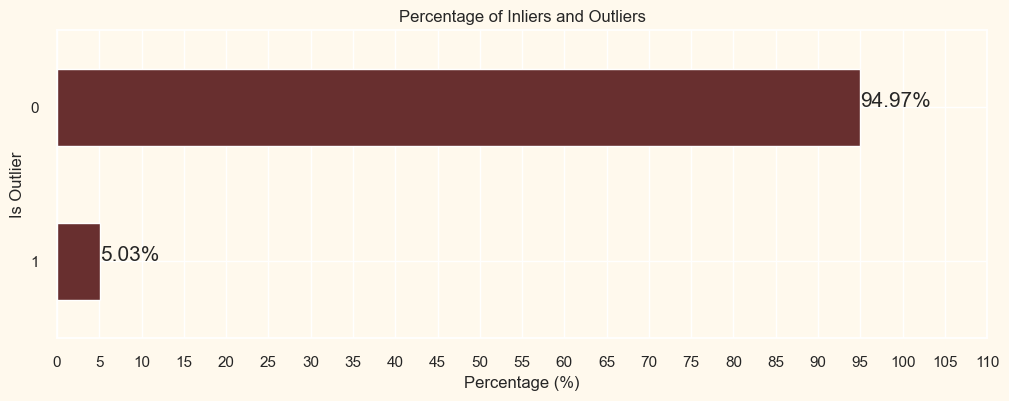

In [214]:
# Calculate the percentage of inliers and outliers
outlier_percentage = customer_data['Is_Outlier'].value_counts(normalize=True) * 100


sns.set(rc={"axes.facecolor":"#FFF9ED","figure.facecolor":"#FFF9ED"})
pallet = ["#682F2F", "#9E726F", "#D6B2B1", "#B9C0C9", "#9F8A78", "#F3AB60"]
cmap = mcolors.ListedColormap(["#682F2F", "#9E726F", "#D6B2B1", "#B9C0C9", "#9F8A78", "#F3AB60"])

# Plotting the percentage of inliers and outliers
plt.figure(figsize=(12, 4))
outlier_percentage.plot(kind='barh', color='#682F2F')

# # Plotting


# plt.figure(figsize=(12, 10))
# sns.barplot(x=description_counts.values, y=description_counts.index, palette=["#682F2F","#B9C0C9", "#9F8A78"])

# Adding the percentage labels on the bars
for index, value in enumerate(outlier_percentage):
    plt.text(value, index, f'{value:.2f}%', fontsize=15)

plt.title('Percentage of Inliers and Outliers')
plt.xticks(ticks=np.arange(0, 115, 5))
plt.xlabel('Percentage (%)')
plt.ylabel('Is Outlier')
plt.gca().invert_yaxis()
plt.show()

#### Inference: 
#### From the above plot, we can observe that about 5% of the customers have been identified as outliers in our dataset. This percentage seems to be a reasonable proportion, not too high to lose a significant amount of data, and not too low to retain potentially noisy data points. It suggests that our isolation forest algorithm has worked well in identifying a moderate percentage of outliers, which will be critical in refining our customer segmentation.

#### Strategy: 
#### Considering the nature of the project (customer segmentation using clustering), it is crucial to handle these outliers to prevent them from affecting the clusters' quality significantly. Therefore, I will separate these outliers for further analysis and remove them from our main dataset to prepare it for the clustering analysis.

#### Separate the identified outliers for further analysis and save them as a separate file (optional).
#### Remove the outliers from the main dataset to prevent them from influencing the clustering process.
#### Drop the Outlier_Scores and Is_Outlier columns as they were auxiliary columns used for the outlier detection process.

In [142]:
# Separate the outliers for analysis
outliers_data = customer_data[customer_data['Is_Outlier'] == 1]

# Remove the outliers from the main dataset
customer_data_cleaned = customer_data[customer_data['Is_Outlier'] == 0]

# Drop the 'Outlier_Scores' and 'Is_Outlier' columns
customer_data_cleaned = customer_data_cleaned.drop(columns=['Outlier_Scores', 'Is_Outlier'])

# Reset the index of the cleaned data
customer_data_cleaned.reset_index(drop=True, inplace=True)

#### We have successfully separated the outliers for further analysis and cleaned our main dataset by removing these outliers. This cleaned dataset is now ready for the next steps in our customer segmentation project, which includes scaling the features and applying clustering algorithms to identify distinct customer segments.

In [143]:
# Getting the number of rows in the cleaned customer dataset
customer_data_cleaned.shape[0]

3118

#### Correlation Analysis: Before we proceed to KMeans clustering, it's essential to check the correlation between features in our dataset. The presence of multicollinearity, where features are highly correlated, can potentially affect the clustering process by not allowing the model to learn the actual underlying patterns in the data, as the features do not provide unique information. This could lead to clusters that are not well-separated and meaningful.

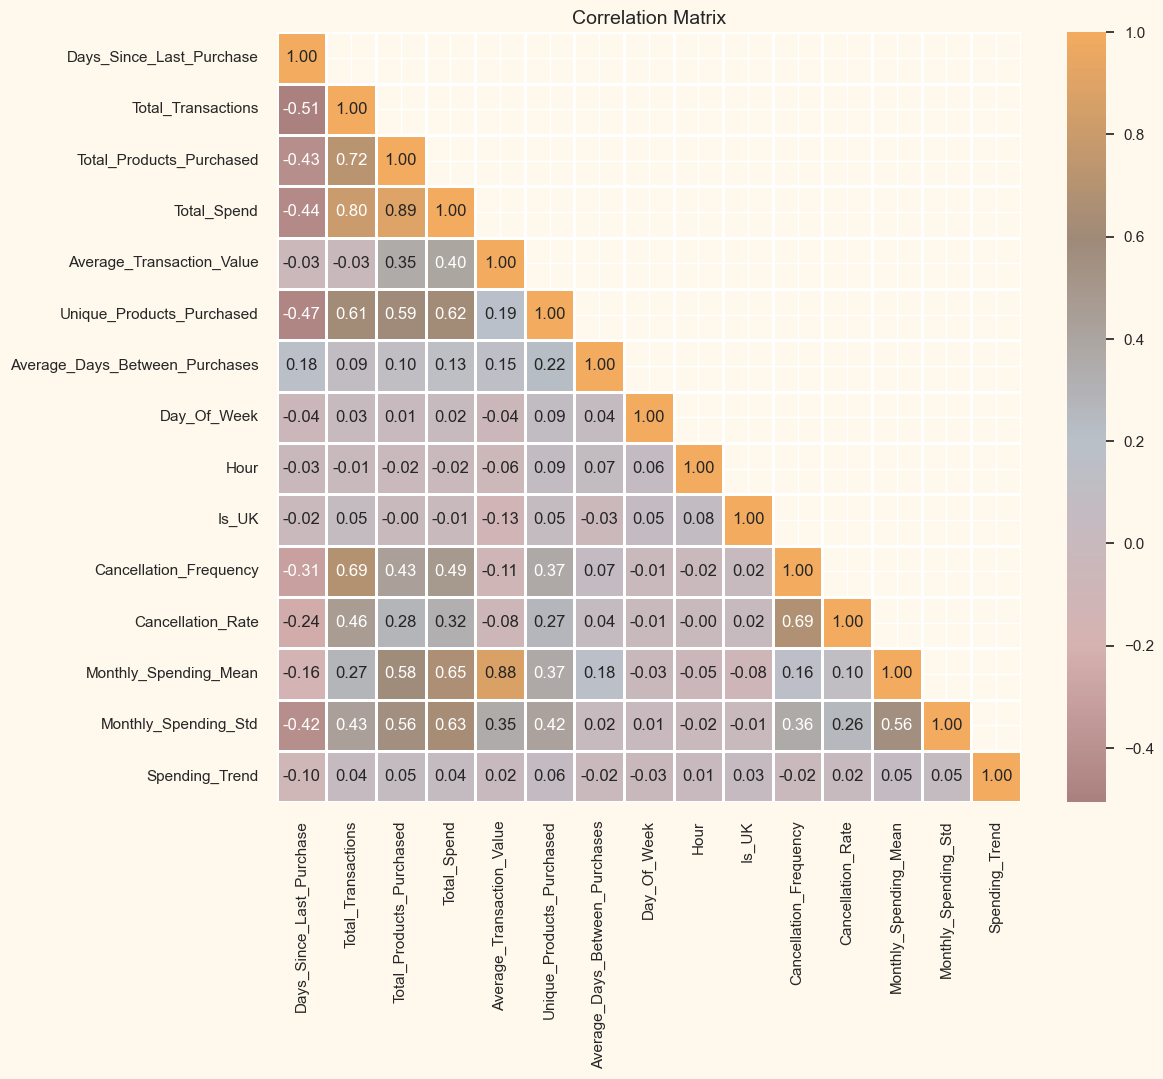

In [188]:
# Reset background style
sns.set_style('whitegrid')

# Calculate the correlation matrix excluding the 'CustomerID' column
corr = customer_data_cleaned.drop(columns=['CustomerID']).corr()

# Define a custom colormap
# colors = ['#ff6200', '#ffcaa8', 'white', '#ffcaa8', '#ff6200']

# # Plotting
sns.set(rc={"axes.facecolor":"#FFF9ED","figure.facecolor":"#FFF9ED"})
pallet = ["#682F2F", "#9E726F", "#D6B2B1", "#B9C0C9", "#9F8A78", "#F3AB60"]
cmap = mcolors.ListedColormap(["#682F2F", "#9E726F", "#D6B2B1", "#B9C0C9", "#9F8A78", "#F3AB60"])

my_cmap = LinearSegmentedColormap.from_list('custom_map', pallet, N=256)

# Create a mask to only show the lower triangle of the matrix (since it's mirrored around its 
# top-left to bottom-right diagonal)
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask, k=1)] = True

# Plot the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr, mask=mask, cmap=my_cmap, annot=True, center=0, fmt='.2f', linewidths=2)
plt.title('Correlation Matrix', fontsize=14)
plt.savefig('Correlation Matrix.png', bbox_inches='tight')
plt.show()

#### Inference: 
#### Looking at the heatmap, we can see that there are some pairs of variables that have high correlations, for instance:

#### Monthly_Spending_Mean and Average_Transaction_Value

#### Total_Spend and Total_Products_Purchased

#### Total_Transactions and Total_Spend

#### Cancellation_Rate and Cancellation_Frequency

#### Total_Transactions and Total_Products_Purchased

#### These high correlations indicate that these variables move closely together, implying a degree of multicollinearity.

#### Before we move forward with the clustering and dimensionality reduction, it's imperative to scale our features. This step holds significant importance, especially in the context of distance-based algorithms like K-means and dimensionality reduction methods like PCA. Here's why:

#### For K-means Clustering: K-means relies heavily on the concept of 'distance' between data points to form clusters. When features are not on a similar scale, features with larger values can disproportionately influence the clustering outcome, potentially leading to incorrect groupings.

# Methodology: 
#### Therefore, to ensure a balanced influence on the model and to reveal the true patterns in the data, I am going to standardize our data, meaning transforming the features to have a mean of 0 and a standard deviation of 1. However, not all features require scaling. Here are the exceptions and the reasons why they are excluded:

#### CustomerID: This feature is just an identifier for the customers and does not contain any meaningful information for clustering.

#### Is_UK: This is a binary feature indicating whether the customer is from the UK or not. Since it already takes a value of 0 or 1, scaling it won't make any significant difference.

#### Day_Of_Week: This feature represents the most frequent day of the week that the customer made transactions. Since it's a categorical feature represented by integers (1 to 7), scaling it would not be necessary.

#### I will proceed to scale the other features in the dataset to prepare it for PCA and K-means clustering.

In [196]:
# Initialize the StandardScaler
scaler = StandardScaler()

# List of columns that don't need to be scaled
columns_to_exclude = ['CustomerID', 'Is_UK', 'Day_Of_Week']

# List of columns that need to be scaled
columns_to_scale = customer_data_cleaned.columns.difference(columns_to_exclude)

# Copy the cleaned dataset
customer_data_scaled = customer_data_cleaned.copy()

# Applying the scaler to the necessary columns in the dataset
customer_data_scaled[columns_to_scale] = scaler.fit_transform(customer_data_scaled[columns_to_scale])

# Display the first few rows of the scaled data
customer_data_scaled.head()

CustomerID  Days_Since_Last_Purchase  Total_Transactions  \
0  3271058.0                 -0.841848           -0.461478   
1  3273053.0                 -0.711798            0.106355   
2  3273850.0                 -0.896036            1.999133   
3  3273954.0                 -0.039874           -0.461478   
4  3274795.0                  0.783775           -0.461478   

   Total_Products_Purchased  Total_Spend  Average_Transaction_Value  \
0                 -0.741085    -0.771151                  -1.110695   
1                  1.121599     1.659108                   2.208729   
2                  0.648883     0.519442                  -0.656910   
3                 -0.626542    -0.500405                  -0.338698   
4                 -0.442001    -0.449271                  -0.192895   

   Unique_Products_Purchased  Average_Days_Between_Purchases  Day_Of_Week  \
0                  -0.828938                       -0.762849            4   
1                   1.161518                        0.235012            4   
2                   2.344657                        0.343949            2   
3                  -0.300005                       -0.229611            2   
4                  -0.634068                        0.158045            3   

       Hour  Is_UK  Cancellation_Frequency  Cancellation_Rate  \
0  0.225072      1                 0.14742           0.056129   
1 -1.102371      0                 0.14742          -0.199919   
2 -0.659890      1                 0.89972          -0.263932   
3  1.994996      1                 0.14742           0.056129   
4  1.110034      1                -0.60488          -0.455968   

   Monthly_Spending_Mean  Monthly_Spending_Std  Spending_Trend  
0              -1.087724             -0.784302       -0.144794  
1               1.988785              1.646972       -0.967174  
2              -0.088324              0.155717        0.203352  
3              -0.173326              0.659470        2.387494  
4              -0.477774             -0.089837       -0.883354

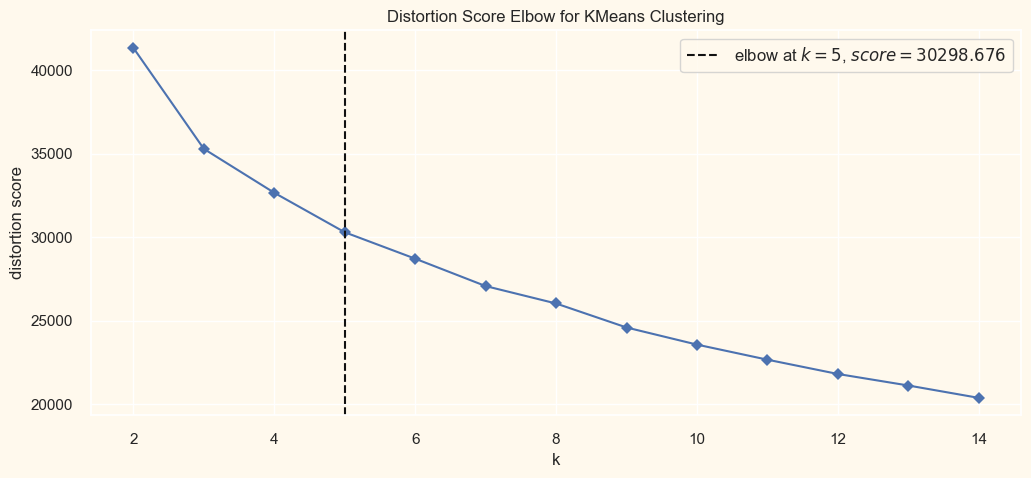

In [197]:
# Set plot style, and background color
customer_data_scaled.set_index('CustomerID', inplace=True)
# sns.set(style='darkgrid', rc={'axes.facecolor': '#fcf0dc'})

sns.set(rc={"axes.facecolor":"#FFF9ED","figure.facecolor":"#FFF9ED"})
pallet = ["#682F2F", "#9E726F", "#D6B2B1", "#B9C0C9", "#9F8A78", "#F3AB60"]
cmap = mcolors.ListedColormap(["#682F2F", "#9E726F", "#D6B2B1", "#B9C0C9", "#9F8A78", "#F3AB60"])

# Set the color palette for the plot
# sns.set_palette(['#ff6200'])

# Instantiate the clustering model with the specified parameters
km = KMeans(init='k-means++', n_init=10, max_iter=100, random_state=0)

# Create a figure and axis with the desired size
fig, ax = plt.subplots(figsize=(12, 5))

# Instantiate the KElbowVisualizer with the model and range of k values, and disable the timing plot
visualizer = KElbowVisualizer(km, k=(2, 15), timings=False, ax=ax)

# Fit the data to the visualizer
visualizer.fit(customer_data_scaled)

# visualizer.savefig('Elbow curve.png', bbox_inches='tight')
plt.savefig('Elbow curve.png', bbox_inches='tight')
# Finalize and render the figure
visualizer.show();

#### Optimal k Value: Elbow Method Insights
#### The optimal value of k for the KMeans clustering algorithm can be found at the elbow point. Using the YellowBrick library for the Elbow method, we observe that the suggested optimal k value is 5. However, we don't have a very distinct elbow point in this case, which is common in real-world data. From the plot, we can see that the inertia continues to decrease significantly up to k=5, indicating that the optimum value of k could be between 3 and 7. To choose the best k within this range, we can employ the silhouette analysis, another cluster quality evaluation method. Additionally, incorporating business insights can help determine a practical k value.

####  Silhouette Method: The silhouette score is the average silhouette coefficient calculated for all data points in a dataset. It provides an overall assessment of the clustering quality, taking into account both cohesion within clusters and separation between clusters. A higher silhouette score indicates a better clustering configuration.

#### Methodology#### 
In the following analysis:#### 

I will initially choose a range of 2-6 for the number of clusters (k) based on the Elbow method from the previous section. Next, I will plot Silhouette scores for each k value to determine the one with the highest score#### .

Subsequently, to fine-tune the selection of the most appropriate k, I will generate Silhouette plots that visually display the silhouette coefficients for each data point within various clu.alysis.

In [215]:
def silhouette_analysis(df, start_k, stop_k, figsize=(15, 16)):
    """
    Perform Silhouette analysis for a range of k values and visualize the results.
    """

    # Set the size of the figure
    plt.figure(figsize=figsize)

    # Create a grid with (stop_k - start_k + 1) rows and 2 columns
    grid = gridspec.GridSpec(stop_k - start_k + 1, 2)

    # Assign the first plot to the first row and both columns
    first_plot = plt.subplot(grid[0, :])

    # First plot: Silhouette scores for different k values
    sns.set_palette(['darkorange'])

    silhouette_scores = []

    # Iterate through the range of k values
    for k in range(start_k, stop_k + 1):
        km = KMeans(n_clusters=k, init='k-means++', n_init=10, max_iter=100, random_state=0)
        km.fit(df)
        labels = km.predict(df)
        score = silhouette_score(df, labels)
        silhouette_scores.append(score)

    best_k = start_k + silhouette_scores.index(max(silhouette_scores))

    plt.plot(range(start_k, stop_k + 1), silhouette_scores, marker='o')
    plt.xticks(range(start_k, stop_k + 1))
    plt.xlabel('Number of clusters (k)')
    plt.ylabel('Silhouette score')
    plt.title('Average Silhouette Score for Different k Values', fontsize=15)

    # Add the optimal k value text to the plot
    optimal_k_text = f'The k value with the highest Silhouette score is: {best_k}'
    plt.text(10, 0.23, optimal_k_text, fontsize=12, verticalalignment='bottom', 
             horizontalalignment='left', bbox=dict(facecolor='#fcc36d', edgecolor='#ff6200', boxstyle='round, pad=0.5'))
             

    # Second plot (subplot): Silhouette plots for each k value
    colors = sns.color_palette("bright")

    for i in range(start_k, stop_k + 1):    
        km = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=100, random_state=0)
        row_idx, col_idx = divmod(i - start_k, 2)

        # Assign the plots to the second, third, and fourth rows
        ax = plt.subplot(grid[row_idx + 1, col_idx])

        visualizer = SilhouetteVisualizer(km, colors=colors, ax=ax)
        visualizer.fit(df)

        # Add the Silhouette score text to the plot
        score = silhouette_score(df, km.labels_)
        ax.text(0.97, 0.02, f'Silhouette Score: {score:.2f}', fontsize=12, \
                ha='right', transform=ax.transAxes, color='red')

        ax.set_title(f'Silhouette Plot for {i} Clusters', fontsize=15)

    plt.tight_layout()
    plt.savefig('Silhouette Plot.png', bbox_inches='tight')
    plt.show()

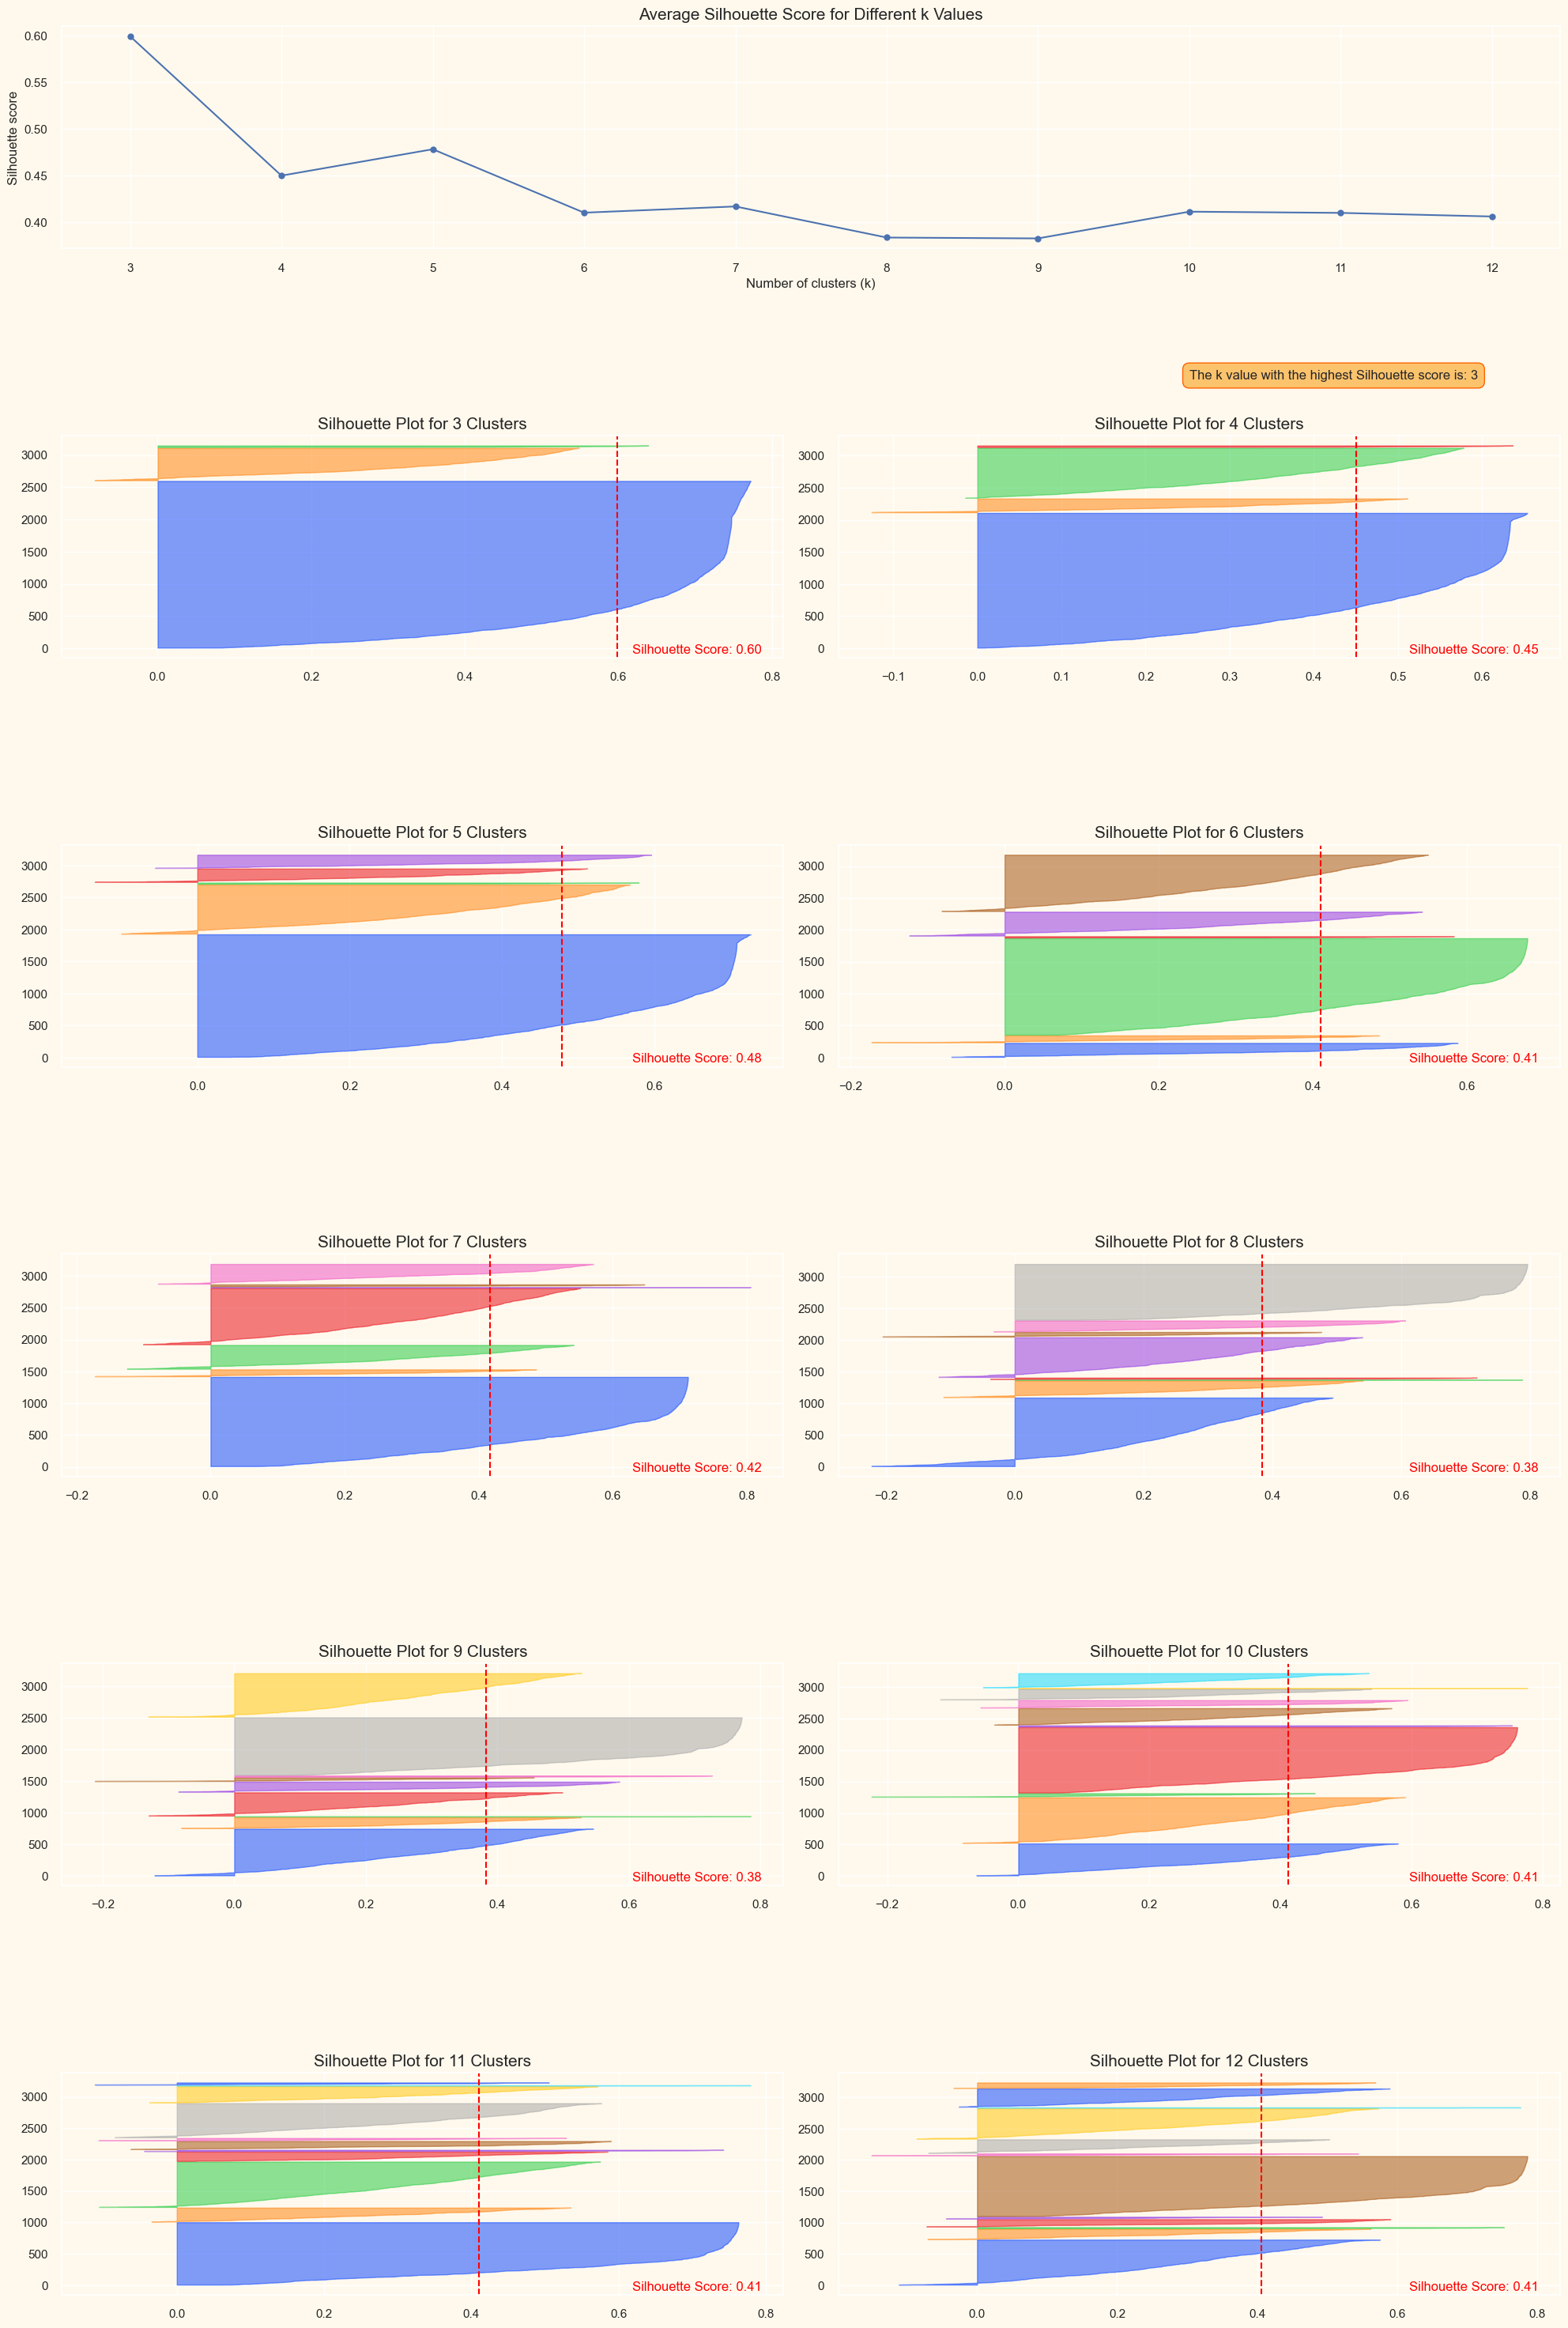

In [216]:
silhouette_analysis(customer_data_scaled[['Total_Transactions', 'Total_Spend','Average_Days_Between_Purchases']], 3, 12, figsize=(20, 50))

#### Optimal k Value: Silhouette Method Insights
#### Based on above guidelines and after carefully considering the silhouette plots, it's clear that choosing ( k = 3 ) is the better option. This choice gives us clusters that are more evenly matched and well-defined, making our clustering solution stronger and more reliable.

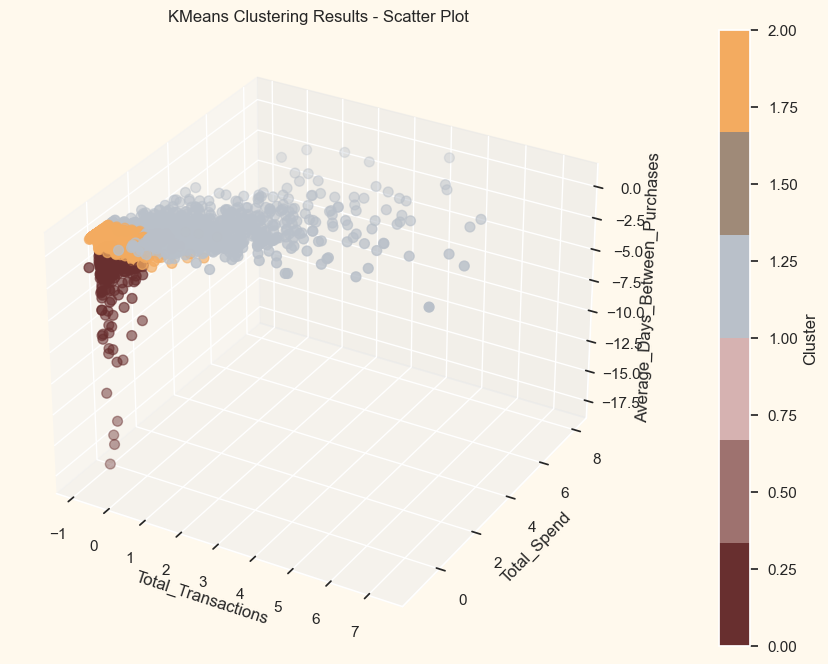

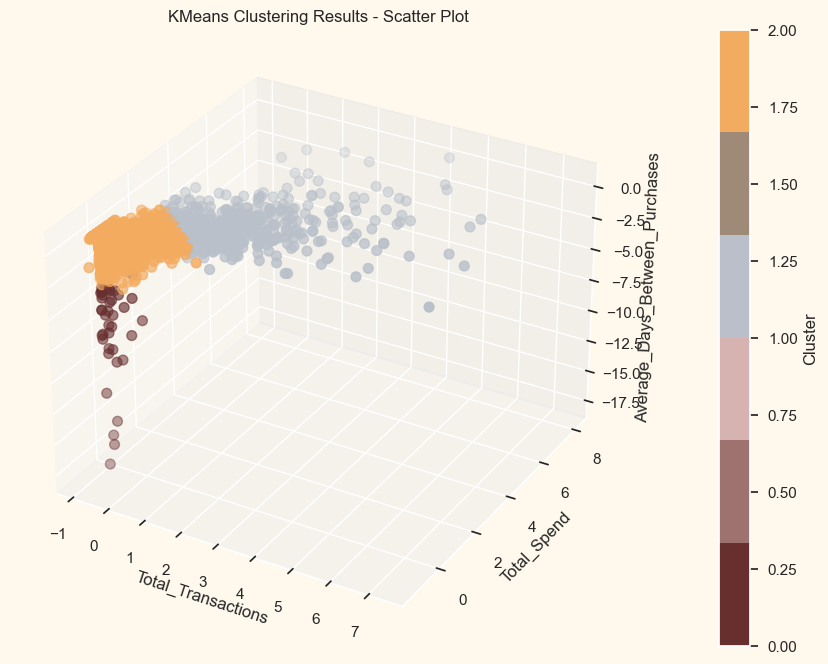

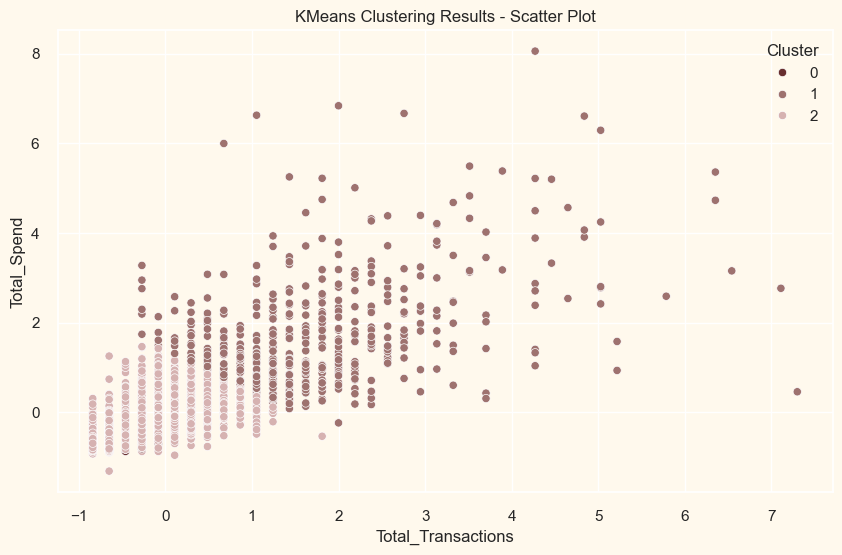

In [231]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

s = ('Total_Transactions', 'Total_Spend','Average_Days_Between_Purchases')
sls = list(s)
# Assuming your data is stored in a variable named 'customer_data_scaled'
 
# Select features for clustering
# features_for_clustering = customer_data_scaled[['Total_Transactions', 'Total_Spend','Cancellation_Frequency']]
features_for_clustering = customer_data_scaled[sls]
# "Monthly_Spending_Mean", "Average_Transaction_Value", "Total_Spend"

# features_for_clustering = customer_data_scaled[['Days_Since_Last_Purchase', 'Total_Transactions', 'Total_Products_Purchased',
#                                                 'Total_Spend', 'Average_Transaction_Value', 'Unique_Products_Purchased',
#                                                 'Average_Days_Between_Purchases', 'Day_Of_Week', 'Hour', 'Is_UK',
#                                                 'Cancellation_Frequency', 'Cancellation_Rate', 'Monthly_Spending_Mean',
#                                                 'Monthly_Spending_Std', 'Spending_Trend']]

sns.set(rc={"axes.facecolor":"#FFF9ED","figure.facecolor":"#FFF9ED"})
pallet = ["#682F2F", "#9E726F", "#D6B2B1", "#B9C0C9", "#9F8A78", "#F3AB60"]
cmap = mcolors.ListedColormap(["#682F2F", "#9E726F", "#D6B2B1", "#B9C0C9", "#9F8A78", "#F3AB60"])


# Create a 3D scatter plot
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot
scatter = ax.scatter(xs=customer_data_scaled[sls[0]],
                    ys=customer_data_scaled[sls[1]],
                    zs=customer_data_scaled[sls[2]],
                    c=customer_data_scaled['Cluster'],
                    cmap=cmap,
                    s=50)

# Set labels
ax.set_xlabel(sls[0])
ax.set_ylabel(sls[1])
ax.set_zlabel(sls[2])

# Add a colorbar
colorbar = fig.colorbar(scatter, ax=ax, orientation='vertical', pad=0.1)
colorbar.set_label('Cluster')

plt.title('KMeans Clustering Results - Scatter Plot')
plt.savefig('Kmeans_clustering_picture.png')
plt.show()





# Set the optimal k value
optimal_k = 3
 
# Apply KMeans clustering
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
customer_data_scaled['Cluster'] = kmeans.fit_predict(features_for_clustering)

# Create a 3D scatter plot
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot
scatter = ax.scatter(xs=customer_data_scaled[sls[0]],
                    ys=customer_data_scaled[sls[1]],
                    zs=customer_data_scaled[sls[2]],
                    c=customer_data_scaled['Cluster'],
                    cmap=cmap,
                    s=50)

# Set labels
ax.set_xlabel(sls[0])
ax.set_ylabel(sls[1])
ax.set_zlabel(sls[2])

# Add a colorbar
colorbar = fig.colorbar(scatter, ax=ax, orientation='vertical', pad=0.1)
colorbar.set_label('Cluster')

plt.title('KMeans Clustering Results - Scatter Plot')
plt.savefig('Kmeans_clustering_picture.png')
plt.show()


# Visualize your clusters or perform any further analysis
# For example, you can use scatter plots, pair plots, etc.
 
# For a simple scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x=sls[0], y=sls[1], hue='Cluster', data=customer_data_scaled, palette=pallet)
plt.xlabel(sls[0])
plt.ylabel(sls[1])
plt.title('KMeans Clustering Results - Scatter Plot')
# plt.savefig('Kmeans_clustering_picture.png')
plt.show()

sns.set(rc={"axes.facecolor":"#FFF9ED","figure.facecolor":"#FFF9ED"})
pallet = ["#682F2F", "#9E726F", "#D6B2B1", "#B9C0C9", "#9F8A78", "#F3AB60"]
cmap = mcolors.ListedColormap(["#682F2F", "#9E726F", "#D6B2B1", "#B9C0C9", "#9F8A78", "#F3AB60"])


# import plotly.graph_objects as go

# Create a 3D scatter plot
try:
    fig = go.Figure()
    
    # Scatter plot
    fig.add_trace(go.Scatter3d(
        x=customer_data_scaled[sls[0]],
        y=customer_data_scaled[sls[1]],
        z=customer_data_scaled[sls[2]],
        mode='markers',
        marker=dict(
            size=5,
            color=customer_data_scaled['Cluster'], # set color to an array/list of desired values
            # colorscale='Viridis', # choose a colorscale
            colorscale=pallet,
            opacity=0.8,
            colorbar=dict(title='Cluster') # colorbar title
        )
    ))
    
    # Set labels
    fig.update_layout(
        title=dict(text='3D Visualization of Customer Clusters', x=0.5),
        scene = dict(
            xaxis=dict(backgroundcolor="#FFF9ED", gridcolor='white', title=sls[0]),
            yaxis=dict(backgroundcolor="#FFF9ED", gridcolor='white', title=sls[1]),
            zaxis=dict(backgroundcolor="#FFF9ED", gridcolor='white', title=sls[2])
            
            # xaxis_title='Total Transactions',
            # yaxis_title='Total Spend',
            # zaxis_title='Cancellation Frequency'
        ),
        width=900,
        height=800
    )
    
    # Show plot
    fig.show()
    # choromap = go.Figure(data=[data], layout=layout)
    # iplot(choromap, validate=False)
    pio.write_html(fig, 'choropleth_kmeans_with_animation.html', auto_play=True)
except:
    print("There is an error in the scatter plot")

In [ ]:
def silhouette_analysis_gmm(df, start_k, stop_k, figsize=(15, 16)):
    """
    Perform Silhouette analysis for a range of k values using Gaussian Mixture Models (GMM) and visualize the results.
    """
    # Set the size of the figure
    plt.figure(figsize=figsize)
    
    # Create a grid with (stop_k - start_k + 1) rows and 2 columns
    grid = gridspec.GridSpec(stop_k - start_k + 1, 2)
    
    # Assign the first plot to the first row and both columns
    first_plot = plt.subplot(grid[0, :])
    
    # First plot: Silhouette scores for different k values
    sns.set_palette(['darkorange'])
    
    silhouette_scores = []
    
    # Iterate through the range of k values
    for k in range(start_k, stop_k + 1):
        gmm = GaussianMixture(n_components=k, random_state=0)
        gmm.fit(df)
        labels = gmm.predict(df)
        score = silhouette_score(df, labels)
        silhouette_scores.append(score)
        
        silhouette_samples_k = silhouette_samples(df, labels)  # Define silhouette_samples within the loop
        
        # Second plot (subplot): Silhouette plots for each k value
        colors = sns.color_palette("bright")
        row_idx, col_idx = divmod(k - start_k, 2)
        ax = plt.subplot(grid[row_idx + 1, col_idx])
        ax.set_title(f'Silhouette Plot for {k} Clusters', fontsize=15)
        
        y_lower = 10
        for j in range(k):
            cluster_j_silhouette_values = silhouette_samples_k[labels == j]
            cluster_j_silhouette_values.sort()
            size_cluster_j = cluster_j_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_j
            color = colors[j]
            ax.fill_betweenx(np.arange(y_lower, y_upper),
                              0, cluster_j_silhouette_values,
                              facecolor=color, edgecolor=color, alpha=0.7)
            ax.text(-0.05, y_lower + 0.5 * size_cluster_j, str(j))
            y_lower = y_upper + 10
        
        ax.set_yticks([])
        ax.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
        ax.axvline(x=score, color="red", linestyle="--")
    
    best_k = start_k + silhouette_scores.index(max(silhouette_scores))
    
    plt.plot(range(start_k, stop_k + 1), silhouette_scores, marker='o')
    plt.xticks(range(start_k, stop_k + 1))
    plt.xlabel('Number of clusters (k)')
    plt.ylabel('Silhouette score')
    plt.title('Average Silhouette Score for Different k Values', fontsize=15)
    
    # Add the optimal k value text to the plot
    optimal_k_text = f'The k value with the highest Silhouette score is: {best_k}'
    plt.text(10, 0.23, optimal_k_text, fontsize=12, verticalalignment='bottom', 
             horizontalalignment='left', bbox=dict(facecolor='#fcc36d', edgecolor='#ff6200', boxstyle='round, pad=0.5'))
    
    plt.tight_layout()
    plt.show()


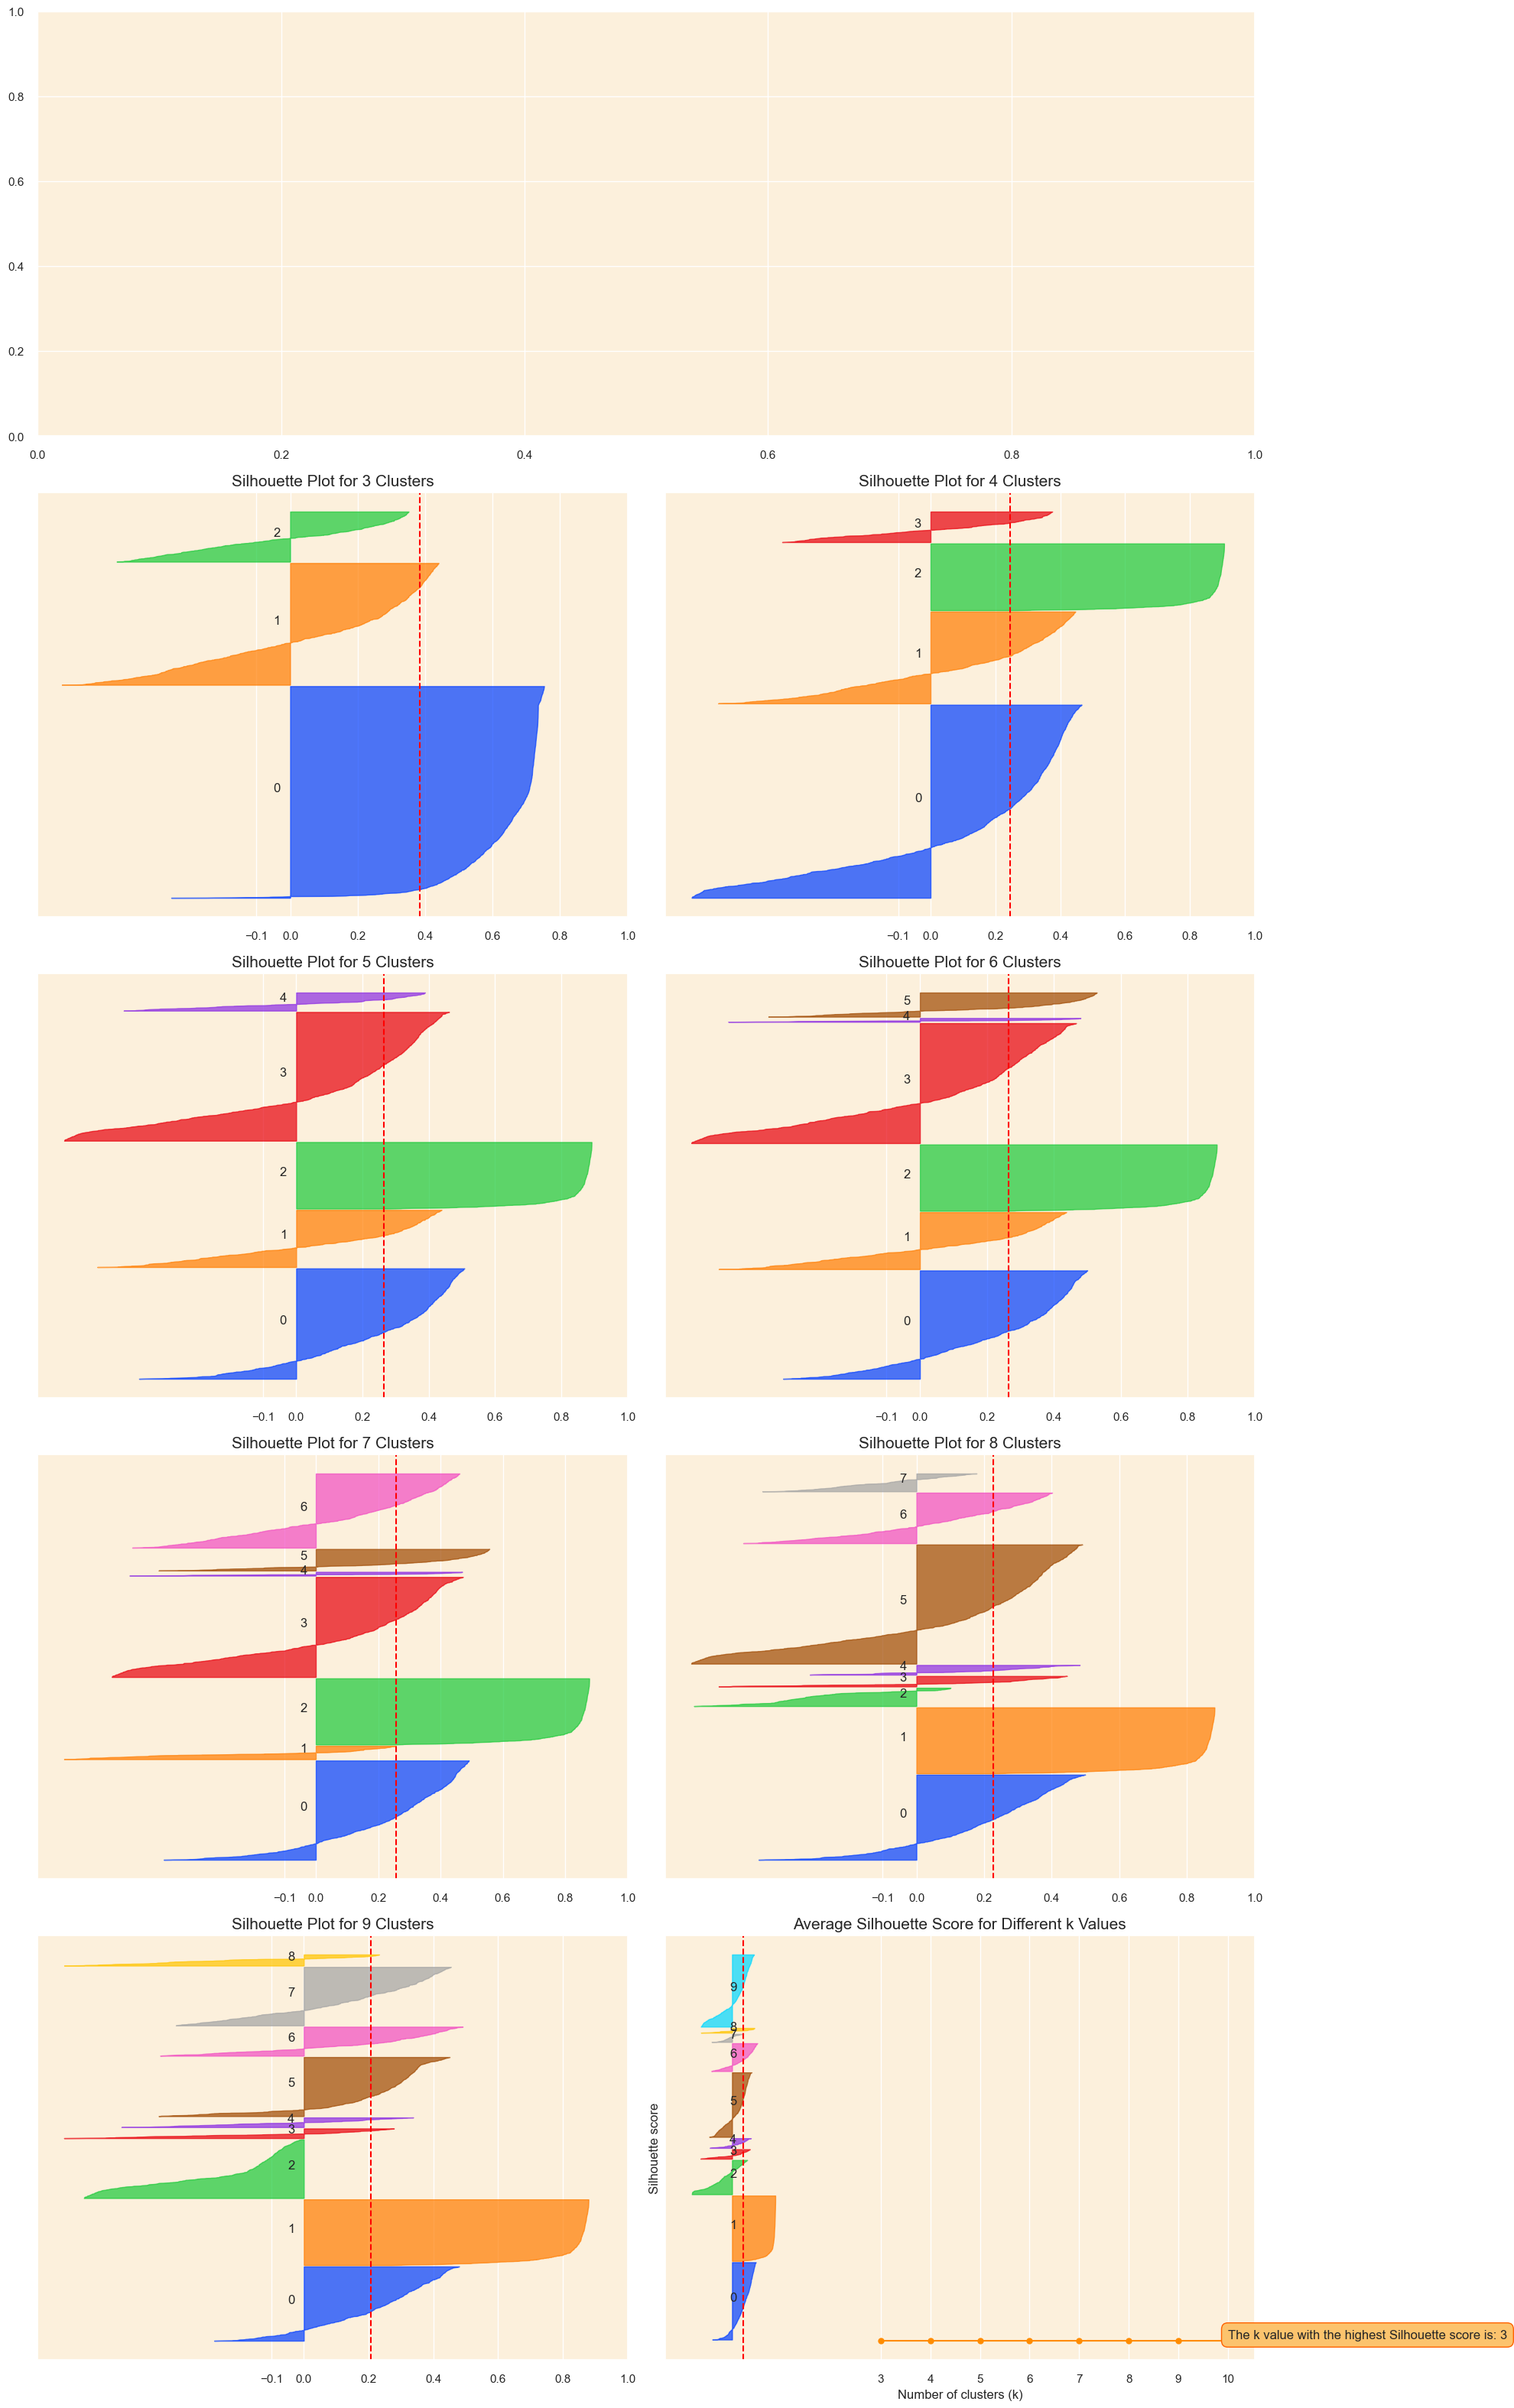

In [175]:
silhouette_analysis_gmm(customer_data_scaled[['Total_Transactions', 'Total_Spend','Average_Days_Between_Purchases']], 3, 10, figsize=(20, 50))

#### Optimal k Value: Silhouette Method Insights
#### Based on above guidelines and after carefully considering the silhouette plots, it's clear that choosing ( k = 3 ) is the better option. This choice gives us clusters that are more evenly matched and well-defined, making our clustering solution stronger and more reliable.

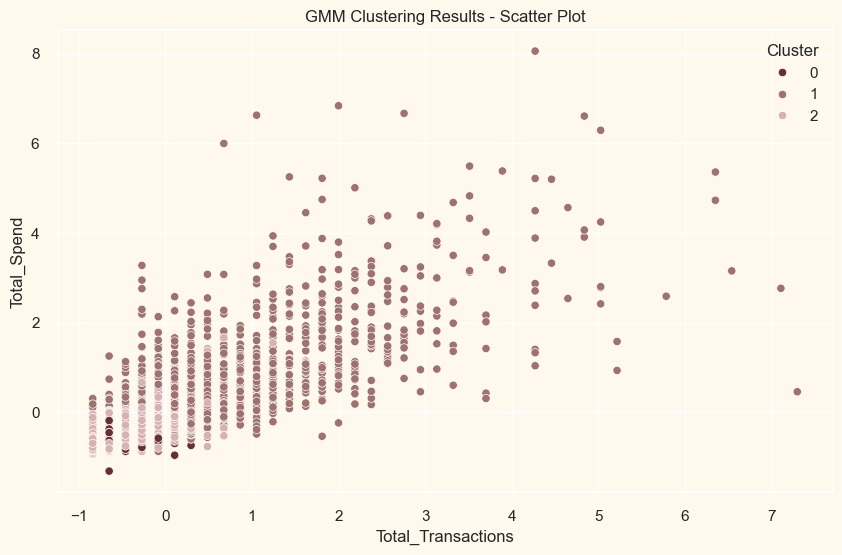

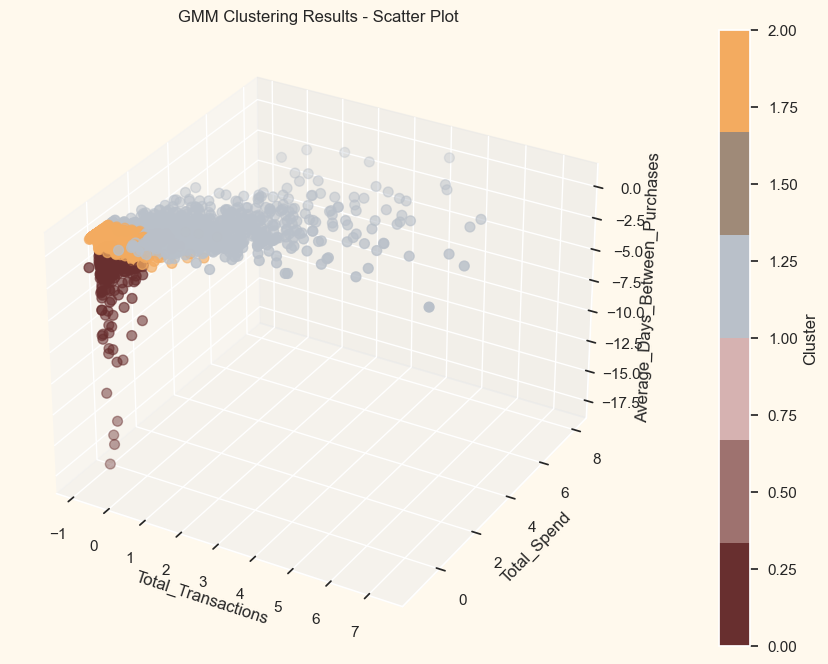

In [230]:
from sklearn.mixture import GaussianMixture

# Assuming your data is stored in a variable named 'customer_data_scaled'

# Select features for clustering
# features_for_clustering = customer_data_scaled[['Monthly_Spending_Mean', 'Average_Transaction_Value','Total_Spend']]

s = ('Total_Transactions', 'Total_Spend','Average_Days_Between_Purchases')
sls = list(s)
# Assuming your data is stored in a variable named 'customer_data_scaled'
 
# Select features for clustering
# features_for_clustering = customer_data_scaled[['Total_Transactions', 'Total_Spend','Cancellation_Frequency']]
features_for_clustering = customer_data_scaled[sls]


# Set the number of components for GMM
n_components = 3

# Create a Gaussian Mixture Model
gmm = GaussianMixture(n_components=n_components, random_state=42)

# Fit the model and predict the clusters
customer_data_scaled['Cluster'] = gmm.fit_predict(features_for_clustering)

sns.set(rc={"axes.facecolor":"#FFF9ED","figure.facecolor":"#FFF9ED"})
pallet = ["#682F2F", "#9E726F", "#D6B2B1", "#B9C0C9", "#9F8A78", "#F3AB60"]
cmap = mcolors.ListedColormap(["#682F2F", "#9E726F", "#D6B2B1", "#B9C0C9", "#9F8A78", "#F3AB60"])


# For a simple scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x=sls[0], y=sls[1], hue='Cluster', data=customer_data_scaled, palette=pallet)
plt.xlabel(sls[0])
plt.ylabel(sls[1])
plt.title('GMM Clustering Results - Scatter Plot')
plt.savefig('gmm_clustering_picture.png')
plt.show()


sns.set(rc={"axes.facecolor":"#FFF9ED","figure.facecolor":"#FFF9ED"})
pallet = ["#682F2F", "#9E726F", "#D6B2B1", "#B9C0C9", "#9F8A78", "#F3AB60"]
cmap = mcolors.ListedColormap(["#682F2F", "#9E726F", "#D6B2B1", "#B9C0C9", "#9F8A78", "#F3AB60"])


# Create a 3D scatter plot
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot
scatter = ax.scatter(xs=customer_data_scaled[sls[0]],
                    ys=customer_data_scaled[sls[1]],
                    zs=customer_data_scaled[sls[2]],
                    c=customer_data_scaled['Cluster'],
                    cmap=cmap,
                    s=50)

# Set labels
ax.set_xlabel(sls[0])
ax.set_ylabel(sls[1])
ax.set_zlabel(sls[2])

# Add a colorbar
colorbar = fig.colorbar(scatter, ax=ax, orientation='vertical', pad=0.1)
colorbar.set_label('Cluster')

plt.title('GMM Clustering Results - Scatter Plot')
plt.savefig('gmm_clustering_picture.png')
plt.show()

# import plotly.graph_objects as go

# Create a 3D scatter plot
try:
    fig = go.Figure()
    
    # Scatter plot
    fig.add_trace(go.Scatter3d(
        x=customer_data_scaled[sls[0]],
        y=customer_data_scaled[sls[1]],
        z=customer_data_scaled[sls[2]],
        mode='markers',
        marker=dict(
            size=5,
            color=customer_data_scaled['Cluster'], # set color to an array/list of desired values
            colorscale=pallet, # choose a colorscale
            opacity=0.8,
            colorbar=dict(title='Cluster') # colorbar title
        )
    ))
    
    # Set labels
    fig.update_layout(
        title=dict(text='3D Visualization of Customer Clusters', x=0.5),
        scene = dict(
            xaxis=dict(backgroundcolor="#FFF9ED", gridcolor='white', title=sls[0]),
            yaxis=dict(backgroundcolor="#FFF9ED", gridcolor='white', title=sls[1]),
            zaxis=dict(backgroundcolor="#FFF9ED", gridcolor='white', title=sls[2])
            
            # xaxis_title='Total Transactions',
            # yaxis_title='Total Spend',
            # zaxis_title='Cancellation Frequency'
        ),
        width=900,
        height=800
    )
    
    # Show plot
    fig.show()
    pio.write_html(fig, 'choropleth_gmm_with_animation.html', auto_play=True)
except:
    print("There is an error in the scatter plot")

In [171]:
# Apply KMeans clustering (as an example)
kmeans = KMeans(n_clusters=3)
kmeans_labels = kmeans.fit_predict(customer_data_scaled[['Total_Transactions', 'Total_Spend','Average_Days_Between_Purchases']])
 
# Apply DBSCAN clustering (as an example)
gmm = GaussianMixture(n_components=n_components, random_state=42)
gmm_labels = gmm.fit_predict(features_for_clustering)
 
# Calculate silhouette score for each clustering result
silhouette_kmeans = silhouette_score(features_for_clustering, kmeans_labels)
silhouette_gmm = silhouette_score(features_for_clustering, gmm_labels)
 
print(f"Silhouette Score (KMeans): {silhouette_kmeans}")
print(f"Silhouette Score (GMM): {silhouette_gmm}")

Silhouette Score (KMeans): 0.6015752109673559
Silhouette Score (GMM): 0.42875614631371367


In [177]:
customer_data_scaled_new = customer_data_scaled.copy(deep=True)
# customer_data_scaled_new.index
customer_data_scaled_new.reset_index(inplace=True)

In [179]:
customer_data_scaled_new

CustomerID  Days_Since_Last_Purchase  Total_Transactions  \
0     3271058.0                 -0.841848           -0.461478   
1     3273053.0                 -0.711798            0.106355   
2     3273850.0                 -0.896036            1.999133   
3     3273954.0                 -0.039874           -0.461478   
4     3274795.0                  0.783775           -0.461478   
...         ...                       ...                 ...   
3113  4227728.0                 -0.798498            0.295633   
3114  4228268.0                  0.101013           -0.272201   
3115  4228333.0                  0.404463           -0.082923   
3116  4228344.0                  0.762100           -0.461478   
3117  4229964.0                 -0.343324            1.052744   

      Total_Products_Purchased  Total_Spend  Average_Transaction_Value  \
0                    -0.741085    -0.771151                  -1.110695   
1                     1.121599     1.659108                   2.208729   
2                     0.648883     0.519442                  -0.656910   
3                    -0.626542    -0.500405                  -0.338698   
4                    -0.442001    -0.449271                  -0.192895   
...                        ...          ...                        ...   
3113                  0.847969     0.267771                  -0.007240   
3114                 -0.117463    -0.179697                   0.081467   
3115                 -0.726540    -0.795965                  -1.269433   
3116                 -0.655633    -0.508291                  -0.361185   
3117                  2.139758     2.968614                   1.586088   

      Unique_Products_Purchased  Average_Days_Between_Purchases  Day_Of_Week  \
0                     -0.828938                       -0.762849            4   
1                      1.161518                        0.235012            4   
2                      2.344657                        0.343949            2   
3                     -0.300005                       -0.229611            2   
4                     -0.634068                        0.158045            3   
...                         ...                             ...          ...   
3113                  -0.021620                        0.076668            2   
3114                  -0.174732                        0.133462            1   
3115                  -0.954211                       -0.222127            1   
3116                  -0.689745                       -0.113073            3   
3117                   0.047976                        0.269408            2   

          Hour  Is_UK  Cancellation_Frequency  Cancellation_Rate  \
0     0.225072      1                 0.14742           0.056129   
1    -1.102371      0                 0.14742          -0.199919   
2    -0.659890      1                 0.89972          -0.263932   
3     1.994996      1                 0.14742           0.056129   
4     1.110034      1                -0.60488          -0.455968   
...        ...    ...                     ...                ...   
3113 -0.217409      1                 0.14742          -0.199919   
3114 -1.544852      1                -0.60488          -0.455968   
3115  1.110034      1                 0.89972          -0.263932   
3116  0.225072      1                -0.60488          -0.455968   
3117 -1.544852      1                 2.40432           1.080323   

      Monthly_Spending_Mean  Monthly_Spending_Std  Spending_Trend  Cluster  
0                 -1.087724             -0.784302       -0.144794        0  
1                  1.988785              1.646972       -0.967174        1  
2                 -0.088324              0.155717        0.203352        1  
3                 -0.173326              0.659470        2.387494        2  
4                 -0.477774             -0.089837       -0.883354        2  
...                     ...                   ...             ...      ...  
3113              

In [180]:
df_customer_standardized

Days_Since_Last_Purchase  Total_Transactions  \
CustomerID                                                 
3271058.0                  -0.841848           -0.461478   
3273053.0                  -0.711798            0.106355   
3273850.0                  -0.896036            1.999133   
3273954.0                  -0.039874           -0.461478   
3274795.0                   0.783775           -0.461478   
...                              ...                 ...   
4227728.0                  -0.798498            0.295633   
4228268.0                   0.101013           -0.272201   
4228333.0                   0.404463           -0.082923   
4228344.0                   0.762100           -0.461478   
4229964.0                  -0.343324            1.052744   

            Total_Products_Purchased  Total_Spend  Average_Transaction_Value  \
CustomerID                                                                     
3271058.0                  -0.741085    -0.771151                  -1.110695   
3273053.0                   1.121599     1.659108                   2.208729   
3273850.0                   0.648883     0.519442                  -0.656910   
3273954.0                  -0.626542    -0.500405                  -0.338698   
3274795.0                  -0.442001    -0.449271                  -0.192895   
...                              ...          ...                        ...   
4227728.0                   0.847969     0.267771                  -0.007240   
4228268.0                  -0.117463    -0.179697                   0.081467   
4228333.0                  -0.726540    -0.795965                  -1.269433   
4228344.0                  -0.655633    -0.508291                  -0.361185   
4229964.0                   2.139758     2.968614                   1.586088   

            Unique_Products_Purchased  Average_Days_Between_Purchases  \
CustomerID                                                              
3271058.0                   -0.828938                       -0.762849   
3273053.0                    1.161518                        0.235012   
3273850.0                    2.344657                        0.343949   
3273954.0                   -0.300005                       -0.229611   
3274795.0                   -0.634068                        0.158045   
...                               ...                             ...   
4227728.0                   -0.021620                        0.076668   
4228268.0                   -0.174732                        0.133462   
4228333.0                   -0.954211                       -0.222127   
4228344.0                   -0.689745                       -0.113073   
4229964.0                    0.047976                        0.269408   

            Day_Of_Week      Hour     Is_UK  Cancellation_Frequency  \
CustomerID                                                            
3271058.0      0.768952  0.225072  0.303511                 0.14742   
3273053.0      0.768952 -1.102371 -3.294771                 0.14742   
3273850.0     -0.309345 -0.659890  0.303511                 0.89972   
3273954.0     -0.309345  1.994996  0.303511                 0.14742   
3274795.0      0.229804  1.110034  0.303511                -0.60488   
...                 ...       ...       ...                     ...   
4227728.0     -0.309345 -0.217409  0.303511                 0.14742   
4228268.0     -0.848493 -1.544852  0.303511                -0.60488   
4228333.0     -0.848493  1.110034  0.303511                 0.89972   
4228344.0      0.229804  0.225072  0.303511                -0.60488   
4229964.0     -0.309345 -1.544852  0.303511                 2.40432   

            Cancellation_Rate  Monthly_Spending_Mean  Monthly_Spending_Std  \
CustomerID                                                                   
3271058.0            0.056129              -1.087724             -0.784302   
3273053.0           -0.199919               1.988785              1.646972   
3273

In [181]:
cluster_centroids

Days_Since_Last_Purchase  Total_Transactions  \
Cluster                                                 
0                       -0.322167           -0.473752   
1                       -0.646453            1.036520   
2                        0.394536           -0.475328   

         Total_Products_Purchased  Total_Spend  Average_Transaction_Value  \
Cluster                                                                     
0                       -0.551604    -0.601683                  -0.576272   
1                        0.974305     1.050447                   0.380868   
2                       -0.429918    -0.462409                  -0.110788   

         Unique_Products_Purchased  Average_Days_Between_Purchases  \
Cluster                                                              
0                        -0.766467                       -1.982949   
1                         0.950102                        0.260556   
2                        -0.382940                        0.176509   

         Day_Of_Week      Hour     Is_UK  Cancellation_Frequency  \
Cluster                                                            
0          -0.105094 -0.140390  0.057895               -0.314744   
1           0.024597 -0.010165 -0.012256                0.723927   
2           0.003624  0.027694 -0.002684               -0.334541   

         Cancellation_Rate  Monthly_Spending_Mean  Monthly_Spending_Std  \
Cluster                                                                   
0                -0.213921              -0.705877             -0.289993   
1                 0.513244               0.679409              0.721847   
2                -0.238645              -0.248780             -0.337367   

         Spending_Trend  
Cluster                  
0              0.050974  
1              0.066983  
2             -0.043674

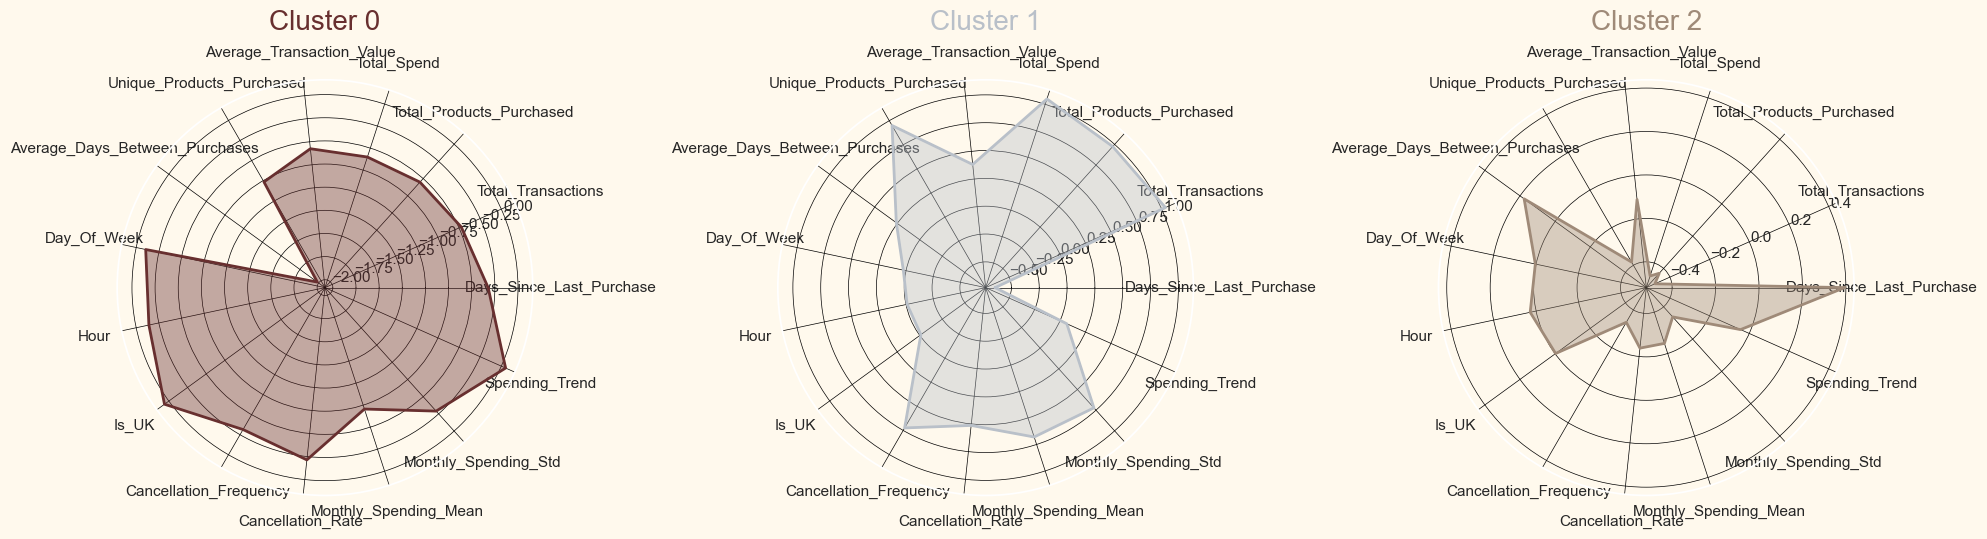

In [210]:
# Setting 'CustomerID' column as index and assigning it to a new dataframe
df_customer = customer_data_scaled_new.set_index('CustomerID')


sns.set(rc={"axes.facecolor":"#FFF9ED","figure.facecolor":"#FFF9ED"})
pallet = ["#682F2F", "#9E726F", "#D6B2B1", "#B9C0C9", "#9F8A78", "#F3AB60"]
cmap = mcolors.ListedColormap(["#682F2F", "#9E726F", "#D6B2B1", "#B9C0C9", "#9F8A78", "#F3AB60"])

# colors = ['#e8000b', '#1ac938', '#023eff']
colors = ["#682F2F","#B9C0C9", "#9F8A78"]

# Standardize the data (excluding the cluster column)
scaler = StandardScaler()
df_customer_standardized = scaler.fit_transform(df_customer.drop(columns=['Cluster'], axis=1))

# Create a new dataframe with standardized values and add the cluster column back
df_customer_standardized = pd.DataFrame(df_customer_standardized, columns=df_customer.columns[:-1], index=df_customer.index)
df_customer_standardized['Cluster'] = df_customer['Cluster']

# Calculate the centroids of each cluster
cluster_centroids = df_customer_standardized.groupby('Cluster').mean()

# Function to create a radar chart
def create_radar_chart(ax, angles, data, color, cluster):
    # Plot the data and fill the area
    ax.fill(angles, data, color=color, alpha=0.4)
    ax.plot(angles, data, color=color, linewidth=2, linestyle='solid')
    
    # Add a title
    ax.set_title(f'Cluster {cluster}', size=20, color=color, y=1.1)

# Set data
labels=np.array(cluster_centroids.columns)
num_vars = len(labels)

# Compute angle of each axis
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()

# The plot is circular, so we need to "complete the loop" and append the start to the end
labels = np.concatenate((labels, [labels[0]]))
angles += angles[:1]

# Initialize the figure
fig, ax = plt.subplots(figsize=(20, 10), subplot_kw=dict(polar=True), nrows=1, ncols=3)

# Create radar chart for each cluster
for i, color in enumerate(colors):
    data = cluster_centroids.loc[i].tolist()
    data += data[:1]  # Complete the loop
    create_radar_chart(ax[i], angles, data, color, i)

# Add input data
ax[0].set_xticks(angles[:-1])
ax[0].set_xticklabels(labels[:-1])

ax[1].set_xticks(angles[:-1])
ax[1].set_xticklabels(labels[:-1])

ax[2].set_xticks(angles[:-1])
ax[2].set_xticklabels(labels[:-1])

# Add a grid
ax[0].grid(color='black', linewidth=0.5)
ax[1].grid(color='black', linewidth=0.5)
ax[2].grid(color='black', linewidth=0.5)

# Display the plot
plt.tight_layout()
plt.savefig('Cluster results.png', bbox_inches='tight')
plt.show()

Analysis:
Spending Patterns: The cluster shows a moderate to high average transaction value and total spend, which suggests these customers are among the more valuable segments.
Purchase Behavior: The number of unique products purchased is relatively low, indicating these customers might be focused on specific types of products or are not experimental in their purchasing.
Transaction Frequency: There's a high value for average days between purchases and days since the last purchase, implying that purchases are infrequent.
Time Patterns: The data for day of the week and hour are not clearly high or low, which might mean there's no strong pattern about when these customers shop, or the data is normalized in a way that doesn't show these patterns clearly.
Geography: The 'Is_UK' axis is not peaked, which could mean this cluster is not specifically or exclusively UK-based customers if 'Is_UK' is a binary variable.
Cancellation Behavior: Both cancellation frequency and rate are not prominent, suggesting that these customers have lower cancellation rates, which is positive.
Variability in Spending: The monthly spending mean is moderate, but the standard deviation (Monthly_Spending_Std) is lower, indicating that their spending is relatively consistent from month to month.
Loyalty and Engagement: Total transactions are moderate, which coupled with the high days between purchases, might suggest that when these customers do purchase, they spend a significant amount.
Recent Engagement: Days since last purchase seems to be on the higher side, indicating that these customers haven't made a purchase recently.
Recommendations:
Engagement Initiatives: Given the high value but infrequent purchases, strategies to increase engagement and decrease the average days between purchases could be beneficial.
Personalization: Tailor marketing to the types of products they frequently buy since they purchase a low variety of unique products.
Loyalty Programs: Introduce or enhance loyalty programs to encourage more frequent purchases, leveraging the fact that when they do buy, they spend significantly.
Re-engagement Campaigns: Target customers who have not made recent purchases with re-engagement campaigns.
Cancellation Analysis: Even though the cancellation rates are low, it would be worth understanding why they occur to further reduce them.
Geographic Expansion: If 'Is_UK' indicates a lower score for UK-based customers, consider targeting similar profiles in other regions.
Consistent Buyers: Since their monthly spending is consistent, these customers may be less price-sensitive, allowing for strategies that focus on value rather than discounts.
For a more comprehensive strategy, you'd also analyze the other clusters to understand how Cluster 0 fits into the overall customer base and to identify opportunities for cross-selling, upselling, and customer lifecycle management. Comparing clusters can also reveal opportunities for transferring the successful strategies from one cluster to another, assuming they share some similarities.

The radar chart you've provided appears to represent a cluster analysis of customer behavior or characteristics. Each axis represents a different variable, and the length of the line along each axis indicates the relative magnitude or importance of that variable within Cluster 1. Here's a detailed analysis of the radar plot for Cluster 1:
Analysis of Variables:
Total Spend: This metric seems to have a moderate value, suggesting that customers in this cluster have an average total spend.
Average Transaction Value: The value is low, indicating that each transaction made by these customers is relatively small.
Total Products Purchased: This is close to the center, which could mean that the number of different products purchased by these customers is low.
Total Transactions: The line is reaching towards the outer edge, suggesting a higher number of transactions.
Days Since Last Purchase: This has a lower value, indicating that the customers in this cluster have made purchases recently.
Spending Trend: This metric is lower, possibly indicating a downward or stagnant spending trend.
Monthly Spending Mean: The value is moderate, which suggests that on average, the monthly spending of these customers is at a mid-range level.
Monthly Spending Std (Standard Deviation): This is low, meaning there is little variability in monthly spending among customers in this cluster.
Cancellation Rate: This variable has a low value, indicating a low cancellation rate.
Cancellation Frequency: It's also low, suggesting cancellations are infrequent.
Is UK: This binary variable is at zero, which likely means that customers in this cluster are not based in the UK.
Hour: The value is low, possibly indicating that the customers in this cluster tend to make purchases at a specific time of day, likely outside of peak hours.
Day Of Week: This variable is also closer to the center, suggesting that there's no specific day of the week when purchases are significantly more or less frequent.
Average Days Between Purchases: This is low, suggesting that customers in this cluster make purchases fairly regularly.
Unique Products Purchased: This has a lower value, which could mean that customers tend to buy the same products rather than a variety of items.
Insights:
Customers in Cluster 1 seem to transact frequently but spend less per transaction, which could indicate that they are regular customers who make smaller, possibly routine purchases.
The low variability in monthly spending and the low cancellation frequency/rate suggest a consistent and reliable customer base.
The fact that they've made purchases recently and regularly could be indicative of loyalty or a subscription-based purchasing behavior.
Recommendations:
Customer Engagement: Since these customers make frequent transactions, personalized engagement strategies could encourage them to increase their average transaction value.
Cross-Selling: There might be an opportunity to introduce these customers to a broader range of products since they tend to purchase unique products less frequently.
Loyalty Programs: Implementing or enhancing loyalty programs might be effective since the cluster shows regular purchasing habits.
Time-Based Marketing: Since the 'Hour' variable is low, identifying the specific times when these customers shop and targeting them with promotions or reminders could increase sales.
Localization: If the business is UK-based, there could be an opportunity to localize marketing efforts or provide location-specific offerings for these customers, if applicable.
Caveats:
It's important to consider the full context of the data, including how the cluster was formed, the total number of clusters, and the relative position of this cluster to others. Additionally, understanding the scale and the exact meaning of each axis would provide more precise insights. This analysis is based on the assumption that higher values on the radar chart are indicative of higher importance or frequency of the variable in question.

The radar chart for Cluster 2 displays different dimensions of customer behavior or characteristics, similar to the previous cluster you showed. Here's an analysis based on the provided chart:
Analysis of Variables:
Total Spend: The length of the line is very short, suggesting customers in this cluster have a very low total spend.
Average Transaction Value: This also has a short line, indicating a low average transaction value.
Total Products Purchased: The line is quite short, suggesting these customers have bought a low number of total products.
Total Transactions: This variable is slightly longer than the previous ones but still on the lower end, indicating a somewhat higher number but still a low quantity of transactions.
Days Since Last Purchase: The value is negative and relatively large, which could mean this cluster comprises customers who haven't made a purchase in a long time.
Spending Trend: The line is near the center, which may suggest a neutral or slightly negative spending trend.
Monthly Spending Mean: The value is low, indicating these customers spend a low amount monthly.
Monthly Spending Std (Standard Deviation): The line is close to the center, suggesting little variability in the monthly spending of these customers.
Cancellation Rate: This metric has a moderate negative value, which might indicate a higher cancellation rate compared to other clusters.
Cancellation Frequency: This has a similar length to the cancellation rate, supporting the suggestion of more frequent cancellations.
Is UK: This binary variable is at zero, indicating that the customers in this cluster are likely not from the UK.
Hour: This has a short length, which could indicate that there is no significant pattern in the hours when purchases are made.
Day Of Week: This variable is also short, suggesting there's no significant trend in purchases on specific days of the week.
Average Days Between Purchases: This line is short and negative, indicating long intervals between purchases.
Unique Products Purchased: The length is very short, suggesting customers in this cluster do not purchase a wide variety of products.
Insights:
Cluster 2 seems to represent a segment of customers who are infrequent shoppers with low engagement, demonstrated by low spend, low transaction value, and few products purchased.
The negative value for days since the last purchase could suggest these are lapsed customers.
A negative value for cancellation rate and frequency indicates a problematic aspect of this cluster, possibly indicating dissatisfaction or a lack of interest in the products or services offered.
Recommendations:
Re-engagement Campaigns: Initiating targeted marketing campaigns to re-engage these customers could be beneficial. Special offers or reminders of the value proposition could bring them back.
Understanding Customer Needs: Conduct surveys or market research to understand why these customers are disengaged, leading to high cancellation rates and infrequent purchases.
Personalized Incentives: Tailoring incentives based on customer's past purchase history may encourage them to purchase more frequently or try different products.
Loyalty Programs: If not already lapsed, incentivizing customers through a loyalty program could encourage more consistent purchasing behavior.
Cancellation Analysis: Investigating the reasons behind the high cancellation rates could provide insights into product or service improvements.
Caveats:
As with any cluster analysis, it is crucial to understand the methodology behind the clustering process. The negative values on the radar plot are particularly notable and should be interpreted carefully, as they could represent data that is standardized around a mean (i.e., z-scores). Understanding the exact meaning of these negative values within the context of the data is essential for accurate insights and recommendations.ue and reduce churn.






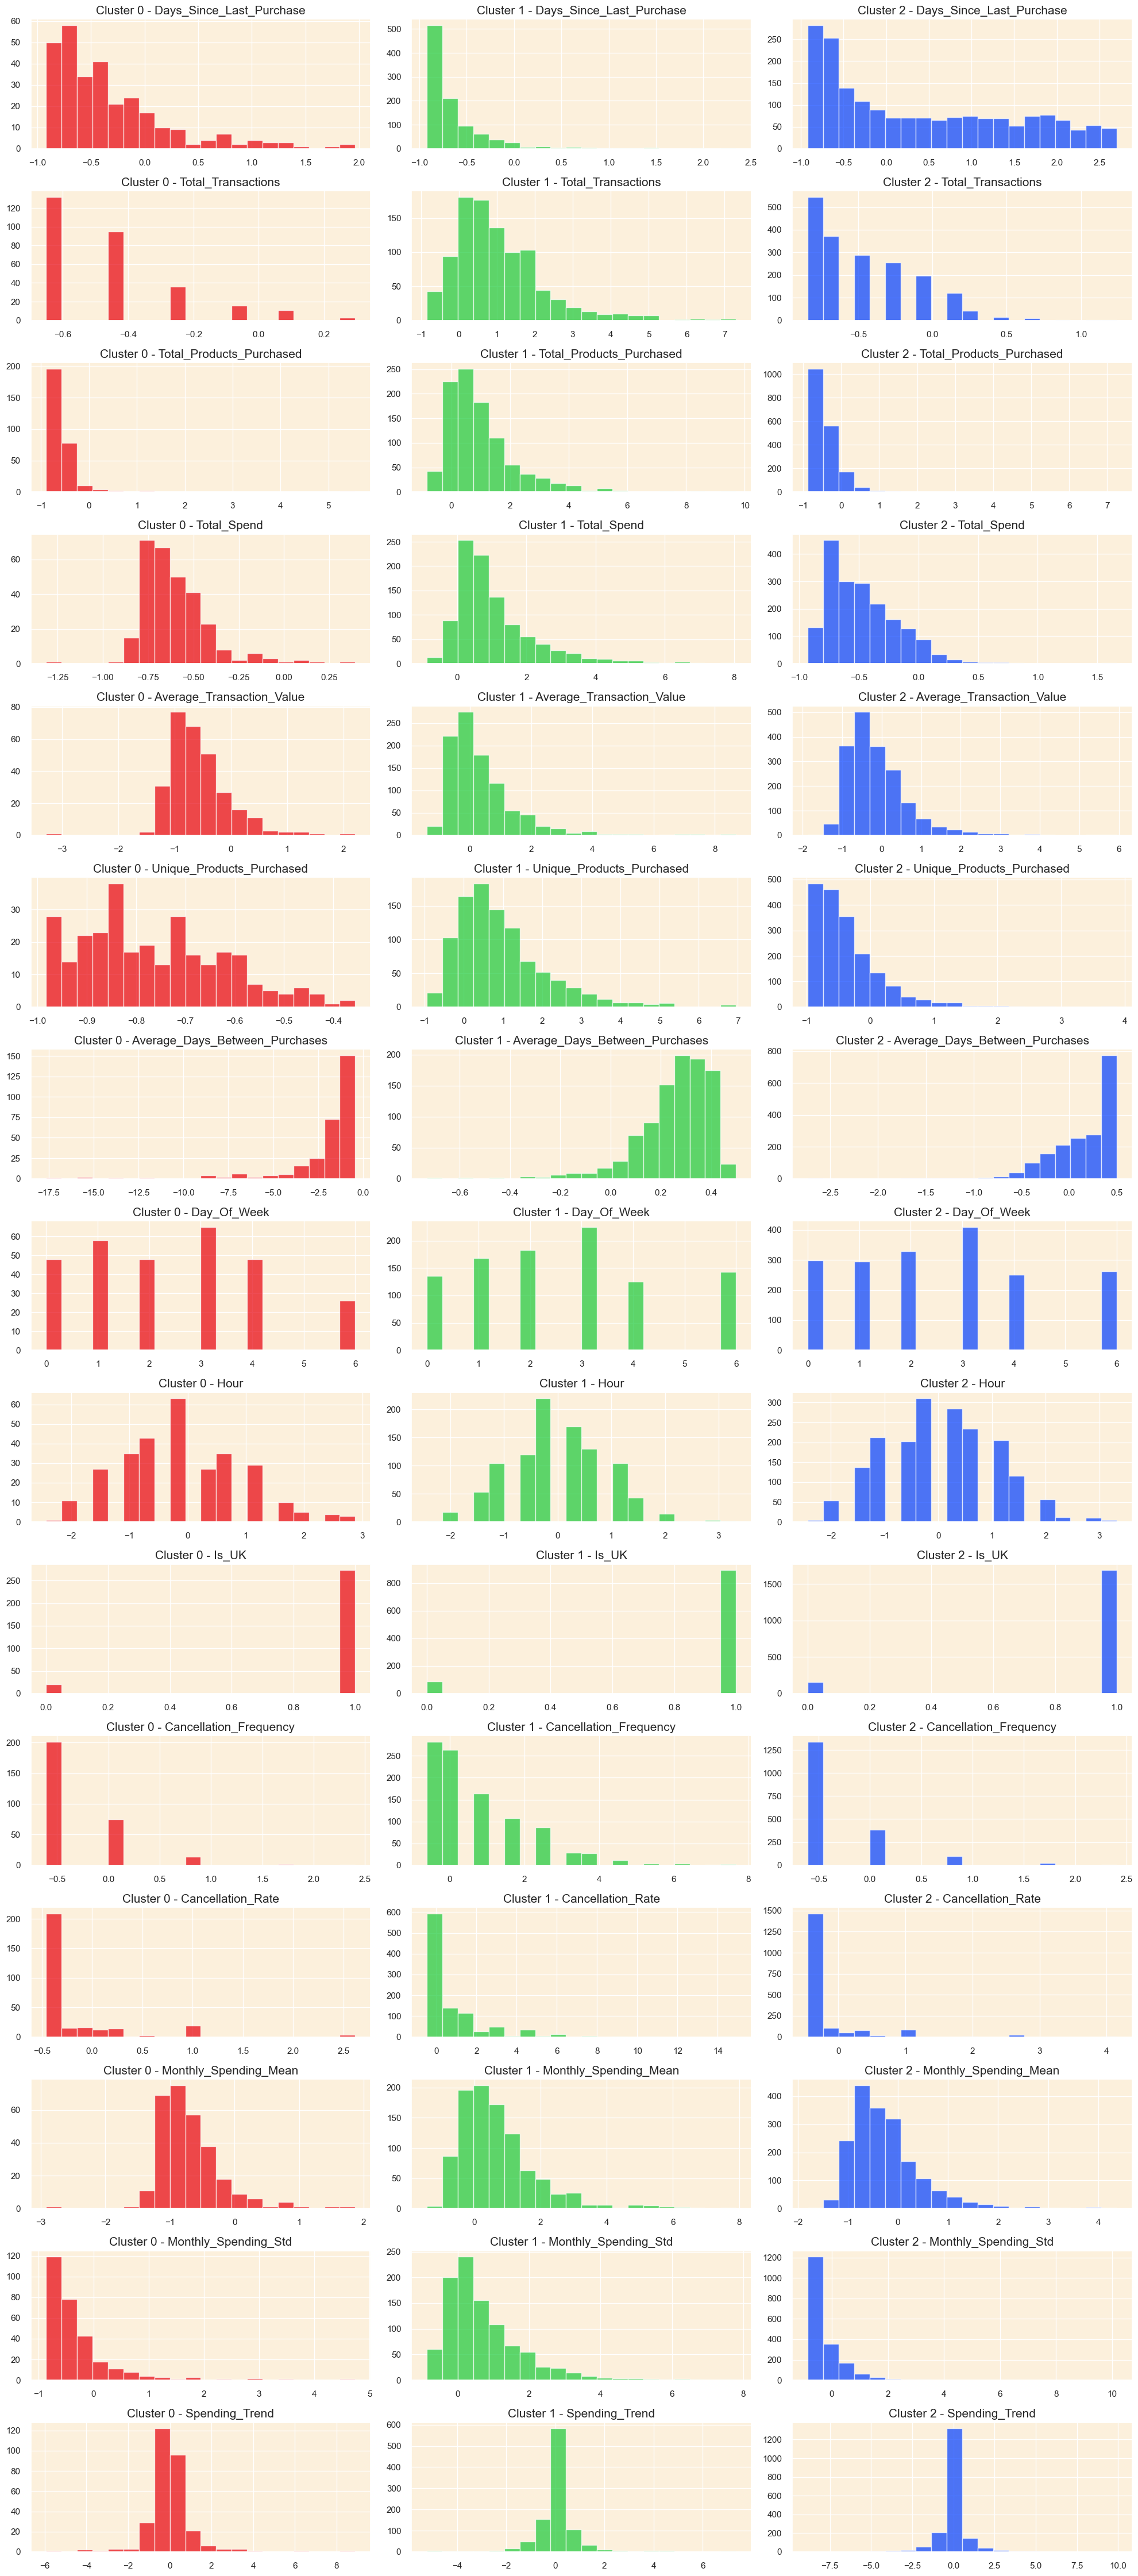

In [183]:
# Plot histograms for each feature segmented by the clusters
features = customer_data_scaled_new.columns[1:-1]
clusters = customer_data_scaled_new['Cluster'].unique()
clusters.sort()

# Setting up the subplots
n_rows = len(features)
n_cols = len(clusters)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 3*n_rows))

# Plotting histograms
for i, feature in enumerate(features):
    for j, cluster in enumerate(clusters):
        data = customer_data_scaled_new[customer_data_scaled_new['Cluster'] == cluster][feature]
        axes[i, j].hist(data, bins=20, color=colors[j], edgecolor='w', alpha=0.7)
        axes[i, j].set_title(f'Cluster {cluster} - {feature}', fontsize=15)
        axes[i, j].set_xlabel('')
        axes[i, j].set_ylabel('')

# Adjusting layout to prevent overlapping
plt.tight_layout()
plt.show()

In [186]:
# Step 1: Extract the CustomerIDs of the outliers and remove their transactions from the main dataframe
outlier_customer_ids = outliers_data['CustomerID'].astype('float').unique()
df_filtered = invoice_df[~invoice_df['CustomerID'].isin(outlier_customer_ids)]

# Step 2: Ensure consistent data type for CustomerID across both dataframes before merging
customer_data_scaled_new['CustomerID'] = customer_data_scaled_new['CustomerID'].astype('float')

# Step 3: Merge the transaction data with the customer data to get the cluster information for each transaction
merged_data = df_filtered.merge(customer_data_scaled_new[['CustomerID', 'Cluster']], on='CustomerID', how='inner')

# Step 4: Identify the top 10 best-selling products in each cluster based on the total quantity sold
best_selling_products = merged_data.groupby(['Cluster', 'StockCode', 'Description'])['Quantity'].sum().reset_index()
best_selling_products = best_selling_products.sort_values(by=['Cluster', 'Quantity'], ascending=[True, False])
top_products_per_cluster = best_selling_products.groupby('Cluster').head(10)

# Step 5: Create a record of products purchased by each customer in each cluster
customer_purchases = merged_data.groupby(['CustomerID', 'Cluster', 'StockCode'])['Quantity'].sum().reset_index()

# Step 6: Generate recommendations for each customer in each cluster
recommendations = []
for cluster in top_products_per_cluster['Cluster'].unique():
    top_products = top_products_per_cluster[top_products_per_cluster['Cluster'] == cluster]
    customers_in_cluster = customer_data_scaled_new[customer_data_scaled_new['Cluster'] == cluster]['CustomerID']
    
    for customer in customers_in_cluster:
        # Identify products already purchased by the customer
        customer_purchased_products = customer_purchases[(customer_purchases['CustomerID'] == customer) & 
                                                         (customer_purchases['Cluster'] == cluster)]['StockCode'].tolist()
        
        # Find top 3 products in the best-selling list that the customer hasn't purchased yet
        top_products_not_purchased = top_products[~top_products['StockCode'].isin(customer_purchased_products)]
        top_3_products_not_purchased = top_products_not_purchased.head(3)
        
        # Append the recommendations to the list
        recommendations.append([customer, cluster] + top_3_products_not_purchased[['StockCode', 'Description']].values.flatten().tolist())

# Step 7: Create a dataframe from the recommendations list and merge it with the original customer data
recommendations_df = pd.DataFrame(recommendations, columns=['CustomerID', 'Cluster', 'Rec1_StockCode', 'Rec1_Description', \
                                                 'Rec2_StockCode', 'Rec2_Description', 'Rec3_StockCode', 'Rec3_Description'])
customer_data_with_recommendations = customer_data_scaled_new.merge(recommendations_df, on=['CustomerID', 'Cluster'], how='right')

In [187]:
# Display 10 random rows from the customer_data_with_recommendations dataframe
customer_data_with_recommendations.set_index('CustomerID').iloc[:, -6:].sample(10, random_state=0)

Rec1_StockCode                   Rec1_Description Rec2_StockCode  \
CustomerID                                                                    
3652341.0           84879      ASSORTED COLOUR BIRD ORNAMENT          16014   
3904003.0           84077  WORLD WAR 2 GLIDERS ASSTD DESIGNS          15036   
4031128.0           84077  WORLD WAR 2 GLIDERS ASSTD DESIGNS          84879   
3803329.0           84077  WORLD WAR 2 GLIDERS ASSTD DESIGNS          84879   
3349505.0           84077  WORLD WAR 2 GLIDERS ASSTD DESIGNS         85099B   
3832251.0           84077  WORLD WAR 2 GLIDERS ASSTD DESIGNS          84879   
3849682.0           84077  WORLD WAR 2 GLIDERS ASSTD DESIGNS          84879   
3453787.0           84077  WORLD WAR 2 GLIDERS ASSTD DESIGNS          84879   
3519604.0           84077  WORLD WAR 2 GLIDERS ASSTD DESIGNS          84879   
3926841.0           84077  WORLD WAR 2 GLIDERS ASSTD DESIGNS          84879   

                         Rec2_Description Rec3_StockCode  \
CustomerID                                                 
3652341.0     SMALL CHINESE STYLE SCISSOR          15036   
3904003.0       ASSORTED COLOURS SILK FAN          21212   
4031128.0   ASSORTED COLOUR BIRD ORNAMENT          16014   
3803329.0   ASSORTED COLOUR BIRD ORNAMENT          16014   
3349505.0         JUMBO BAG RED RETROSPOT          84879   
3832251.0   ASSORTED COLOUR BIRD ORNAMENT          16014   
3849682.0   ASSORTED COLOUR BIRD ORNAMENT          16014   
3453787.0   ASSORTED COLOUR BIRD ORNAMENT          16014   
3519604.0   ASSORTED COLOUR BIRD ORNAMENT          22616   
3926841.0   ASSORTED COLOUR BIRD ORNAMENT          16014   

                           Rec3_Description  
CustomerID                                   
3652341.0         ASSORTED COLOURS SILK FAN  
3904003.0   PACK OF 72 RETROSPOT CAKE CASES  
4031128.0       SMALL CHINESE STYLE SCISSOR  
3803329.0       SMALL CHINESE STYLE SCISSOR  
3349505.0     ASSORTED COLOUR BIRD ORNAMENT  
3832251.0       SMALL CHINESE STYLE SCISSOR  
3849682.0       SMALL CHINESE STYLE SCISSOR  
3453787.0       SMALL CHINESE STYLE SCISSOR  
3519604.0        PACK OF 12 LONDON TISSUES   
3926841.0       SMALL CHINESE STYLE SCISSOR